In [1]:
!pip install nibabel
!pip install medicaltorch
# !pip install visdom

In [2]:
#@title [Please run] Custom transformations 
import numpy as np
import numbers
import torchvision.transforms.functional as F
from torchvision import transforms
from PIL import Image
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
import torchvision.transforms.functional

class MTTransform(object):

    def __call__(self, sample):
        raise NotImplementedError("You need to implement the transform() method.")

    def undo_transform(self, sample):
        raise NotImplementedError("You need to implement the undo_transform() method.")


class UndoCompose(object):
    def __init__(self, compose):
        self.transforms = compose.transforms

    def __call__(self):
        for t in self.transforms:
            img = t.undo_transform(img)
        return img


class UndoTransform(object):
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, sample):
        return self.transform.undo_transform(sample)


class ToTensor(MTTransform):
    """Convert a PIL image or numpy array to a PyTorch tensor."""

    def __init__(self, labeled=True):
        self.labeled = labeled

    def __call__(self, sample):
        rdict = {}
        input_data = sample['input']

        if isinstance(input_data, list):
            ret_input = [F.to_tensor(item)
                         for item in input_data]
        else:
            ret_input = F.to_tensor(input_data)

        rdict['input'] = ret_input

        if self.labeled:
            gt_data = sample['gt']
            if gt_data is not None:
                if isinstance(gt_data, list):
                    ret_gt = [F.to_tensor(item)
                              for item in gt_data]
                else:
                    ret_gt = F.to_tensor(gt_data)

                rdict['gt'] = ret_gt

        sample.update(rdict)
        return sample


class ToPIL(MTTransform):
    def __init__(self, labeled=True):
        self.labeled = labeled

    def sample_transform(self, sample_data):
        # Numpy array
        if not isinstance(sample_data, np.ndarray):
            input_data_npy = sample_data.numpy()
        else:
            input_data_npy = sample_data

        input_data_npy = np.transpose(input_data_npy, (1, 2, 0))
        input_data_npy = np.squeeze(input_data_npy, axis=2)
        input_data = Image.fromarray(input_data_npy, mode='F')
        return input_data

    def __call__(self, sample):
        rdict = {}
        input_data = sample['input']

        if isinstance(input_data, list):
            ret_input = [self.sample_transform(item)
                         for item in input_data]
        else:
            ret_input = self.sample_transform(input_data)

        rdict['input'] = ret_input

        if self.labeled:
            gt_data = sample['gt']

            if isinstance(gt_data, list):
                ret_gt = [self.sample_transform(item)
                          for item in gt_data]
            else:
                ret_gt = self.sample_transform(gt_data)

            rdict['gt'] = ret_gt

        sample.update(rdict)
        return sample


class res(MTTransform):
    """Make a center crop of a specified size.

    :param segmentation: if it is a segmentation task.
                         When this is True (default), the crop
                         will also be applied to the ground truth.
    """
    def __init__(self, size, labeled=True):
        self.size = size
        self.labeled = labeled

    @staticmethod
    def propagate_params(sample, params):
        input_metadata = sample['input_metadata']
        input_metadata["__centercrop"] = params
        return input_metadata

    @staticmethod
    def get_params(sample):
        input_metadata = sample['input_metadata']
        return input_metadata["__centercrop"]

    def __call__(self, sample):
        rdict = {}
        input_data = sample['input']

        w, h = input_data.size
        th, tw = self.size
        fh = int(round((h - th) / 2.))
        fw = int(round((w - tw) / 2.))

        params = (fh, fw, w, h)
        self.propagate_params(sample, params)

        input_data = torchvision.transforms.functional.resize(input_data, self.size)
        rdict['input'] = input_data

        if self.labeled:
            gt_data = sample['gt']
            gt_metadata = sample['gt_metadata']
            gt_data = torchvision.transforms.functional.resize(gt_data, self.size)
            gt_metadata["__centercrop"] = (fh, fw, w, h)
            rdict['gt'] = gt_data


        sample.update(rdict)
        return sample

    def undo_transform(self, sample):
        rdict = {}
        input_data = sample['input']
        fh, fw, w, h = self.get_params(sample)
        th, tw = self.size

        pad_left = fw
        pad_right = w - pad_left - tw
        pad_top = fh
        pad_bottom = h - pad_top - th

        padding = (pad_left, pad_top, pad_right, pad_bottom)
        input_data = F.pad(input_data, padding)
        rdict['input'] = input_data

        sample.update(rdict)
        return sample







In [3]:
# for custom dataset class
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
import glob
import nibabel as nib
import os
from medicaltorch import datasets as mt_datasets
from medicaltorch import transforms as mt_transforms
import matplotlib.pyplot as plt
from google.colab import drive
import torch.nn as nn
import math
from torch.utils.data import DataLoader

In [4]:
drive.mount('/gdrive')
ROOT_DIR = "/gdrive/My Drive/MM-WHS 2017 Dataset/"
# ROOT_DIR = 'drive/MyDrive/MM-WHS 2017 Dataset/'
mri_input_filename = os.path.join(ROOT_DIR,'ct_train',
                                          'ct_train_1001_image.nii.gz')
mri_gt_filename = os.path.join(ROOT_DIR,'ct_train',
                                          'ct_train_1001_label.nii.gz')

pair = mt_datasets.SegmentationPair2D(mri_input_filename, mri_gt_filename)
slice_pair = pair.get_pair_slice(159)
input_slice = slice_pair["input"]
gt_slice = slice_pair["gt"]

Mounted at /gdrive


In [5]:
# print(input_slice.shape)
# img = input_slice
# plt.imshow(img,cmap = 'gray')
# plt.show()
# img = gt_slice
# plt.imshow(img,cmap = 'gray')
# plt.show()

# img_data,seg_data = pair.get_pair_data()
# img_data.shape
# seg_data.shape

In [6]:

img_list = sorted(glob.glob(os.path.join(ROOT_DIR, "mr_train")+"/*image.nii.gz"))
label_list = sorted(glob.glob(os.path.join(ROOT_DIR, "mr_train")+"/*label.nii.gz"))

In [7]:
filename_pairs = [(os.path.join(ROOT_DIR,'mr_train',x),os.path.join(ROOT_DIR,'mr_train',y)) for x,y in zip(img_list,label_list)]

img_list2 = sorted(glob.glob(os.path.join(ROOT_DIR, "ct_train")+"/*image.nii.gz"))
label_list2 = sorted(glob.glob(os.path.join(ROOT_DIR, "ct_train")+"/*label.nii.gz"))

filename_pairs2 = [(os.path.join(ROOT_DIR,'ct_train',x),os.path.join(ROOT_DIR,'ct_train',y)) for x,y in zip(img_list2,label_list2)]

In [8]:
from torchvision import transforms, utils
from skimage import io, transform

'''
Subset data to ony get 1 sample out
'''
dat=filename_pairs[0]
lbl=filename_pairs2[0]

filename_pairs.clear()
filename_pairs2.clear()

filename_pairs.append(dat)
filename_pairs2.append(lbl)

print(filename_pairs)

# print(type(filename_pairs[0]))
# print(len(filename_pairs2[0]))


train_transform = transforms.Compose([

        # transforms.Resize((256,256)),
        # transforms.ToPILImage(),
        # transforms.ToTensor()
        res((64,64)),
        mt_transforms.ToTensor()
        
        ]
)

train_dataset = mt_datasets.MRI2DSegmentationDataset(filename_pairs,transform=train_transform)
train_dataset2= mt_datasets.MRI2DSegmentationDataset(filename_pairs2,transform=train_transform)


[('/gdrive/My Drive/MM-WHS 2017 Dataset/mr_train/mr_train_1001_image.nii.gz', '/gdrive/My Drive/MM-WHS 2017 Dataset/mr_train/mr_train_1001_label.nii.gz')]


In [9]:

dataloader = DataLoader(train_dataset, batch_size=1,collate_fn=mt_datasets.mt_collate)
dataloader2= DataLoader(train_dataset2, batch_size=1, collate_fn=mt_datasets.mt_collate)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:132: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))


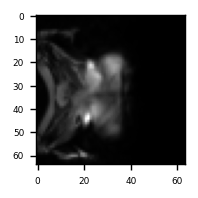

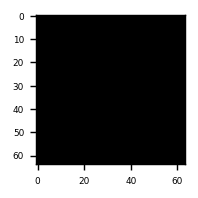

In [10]:
import matplotlib
matplotlib.rcParams.update({'font.size': 5})
for _ in range(1):
    for i, batch in enumerate(zip(dataloader, dataloader2)):
      
        '''
        CT IMAGE
        '''
        plt.figure(figsize = (1.5,1.5), dpi=128)
        plt.imshow(batch[0]["input"][0].detach().cpu().permute(1,2,0)[:,:,0],cmap = 'gray')
        plt.tight_layout()
        plt.show()

        '''
        CT seg mask
        '''

        plt.figure(figsize = (1.5,1.5), dpi=128)
        plt.imshow(batch[0]["gt"][0].detach().cpu().permute(1,2,0)[:,:,0],cmap = 'gray')
        plt.tight_layout()
        plt.show()


        '''
        MRI image
        '''

        # plt.figure(figsize = (1.5,1.5), dpi=128)
        # plt.imshow(batch[1]["input"][0].detach().cpu().permute(1,2,0)[:,:,0],cmap = 'gray')
        # plt.tight_layout()
        # plt.show()

        break
'''
visualize images
'''
def vis(image):
    plt.imshow(image[0].detach().cpu().permute(1,2,0)[:,:,0],cmap='gray')
    plt.show()

In [11]:
# https://discuss.pytorch.org/t/implementing-truncated-normal-initializer/4778/21
# https://github.com/tensorflow/tensorflow/blob/85c8b2a817f95a3e979ecd1ed95bff1dc1335cff/tensorflow/python/ops/random_ops.py#L163

def truncated_normal(t, mean=0.0, std=0.01):
    torch.nn.init.normal_(t, mean=mean, std=std)
    while True:
      cond = torch.logical_or(t < mean - 2*std, t > mean + 2*std)
      if not torch.sum(cond):
        break
      t = torch.where(cond.cuda(), torch.nn.init.normal_(torch.ones(t.shape), mean=mean, std=std).cuda(), t.cuda()).cuda()
      
    # return t

def compute_conv_output(H, K, S):
  return int(((H-K+2*0)/S)+1)

def compute_padding(out, H, K, S):
  return int((S*(out-1)-H+K)/2)

def compute_padding_deconv(out, H, K, S):
  return int((-out+(H-1)*S+K)/2)

def compute_maxpool_padding(S, H, f):
  '''
  H2=(H1-f)/s+1
  '''
  return int((S*(H-1)-H+f)/2)


In [12]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
        )

    def forward(self, x):
        return x + self.block(x)

In [13]:

class General_Conv2D(nn.Module):
    # @torch.no_grad()
    def init_weights(self, n):
      if type(n) == nn.Conv2d:
          truncated_normal(n.weight, 0.01)
          

    def __init__(self, in_features=0, out_features=64, k=7, s=1, stddev=0.01, do_relu=True, keep_rate=None, relu_factor=0, norm_type=None, train=True, padding=False, input_dim=0):
        super(General_Conv2D, self).__init__()
        self.std=stddev
        self.keep_rate=keep_rate
        self.relu_factor=relu_factor
        self.norm_type=norm_type
        self.do_relu=do_relu
        self.k=k
        self.s=s
        self.padding=padding

        if not keep_rate is None:
          self.dropout = nn.Dropout(p=keep_rate)
        
        if norm_type=='Batch':
          # if train:
            # self.batchnorm=nn.BatchNorm2d(num_features=out_features, momentum=0.1, affine=True).train()
          # else:
            self.batchnorm=nn.BatchNorm2d(num_features=out_features, momentum=0.1, affine=True)
        elif norm_type=='Ins':
          # if train:
            # self.instancenorm=nn.InstanceNorm2d(num_features=out_features).train()
          # else:
            self.instancenorm=nn.InstanceNorm2d(num_features=out_features)
        
        self.relu=nn.ReLU()
        self.lrealu=nn.LeakyReLU()
        
        self.w= nn.Parameter(torch.randn(out_features, in_features, k,k))
        truncated_normal(self.w)
        self.b=nn.Parameter(torch.randn(out_features))

    def forward(self, x):

        '''
        initialize weights
        '''
        
        if self.padding==False:
          x = torch.nn.functional.conv2d(x, self.w, self.b, padding=0)

        else:
          
          x = torch.nn.functional.conv2d(x, self.w, self.b, padding=compute_padding(x.shape[-1], x.shape[-1], self.k, self.s))
        
        '''
        dropout
        '''
        if not self.keep_rate is None:
          x=self.dropout(x)

        '''
        norm
        '''
        if (self.norm_type=='Batch'):
          x=self.batchnorm(x)
        elif (self.norm_type=='Ins'):
          x=self.instancenorm(x)

        '''
        act fnc
        '''
        if (self.do_relu==True):
          if (self.relu_factor==0):
            x=self.relu(x)
          else:
            x=self.lrealu(x)
        
        

        return x

        # return x + self.block(x)


class Resnet_Block(nn.Module):
    def __init__(self, in_features, out_features , padding="REFLECT", norm_type=None, keep_rate=0.75):
        super(Resnet_Block, self).__init__()

        if padding=='REFLECT':
          pad_layer=nn.ReflectionPad2d(1)
        elif padding=='CONSTANT':
          pad_layer=nn.ZeroPad2d(1)
        else: # SYMMETRIC
          pad_layer=nn.ReplicationPad2d(1)

        self.block = nn.Sequential(
            pad_layer,
            General_Conv2D(in_features, out_features, k=3, s=1, stddev=0.01, norm_type=norm_type, keep_rate=keep_rate, padding=False),
            pad_layer,
            General_Conv2D(in_features, out_features, k=3, s=1, stddev=0.01, do_relu=False, norm_type=norm_type, keep_rate=keep_rate, padding=False)
        )

      
        self.relu=nn.ReLU()

    def forward(self, x):      

        out = self.block(x)
  
        return self.relu(out+x)

class Resnet_Block_ds(nn.Module):
    def __init__(self, in_features=0, out_features=0, padding="REFLECT",dim=0, norm_type=None, keep_rate=0.75):
        super(Resnet_Block_ds, self).__init__()

        self.in_features=in_features
        self.out_features=out_features

        if padding=='REFLECT':
          pad_layer=nn.ReflectionPad2d(1)
        elif padding=='CONSTANT':
          pad_layer=nn.ZeroPad2d(1)
        else: # SYMMETRIC
          pad_layer=nn.ReplicationPad2d(1)


        self.block = nn.Sequential(
            
            pad_layer,
            General_Conv2D(in_features, out_features, k=3, s=1, stddev=0.01, norm_type=norm_type, keep_rate=keep_rate, padding=False),
            pad_layer,
            General_Conv2D(out_features, out_features, k=3, s=1, stddev=0.01, do_relu=False, norm_type=norm_type, keep_rate=keep_rate, padding=False)
        )

    def forward(self, x):
     
        out = self.block(x)
        '''
        pad channel dim
        '''
        pd=(self.out_features-self.in_features) // 2

        padding = torch.zeros(x.shape[0], pd, x.shape[2], x.shape[3]).cuda()
        padded_inp = torch.cat((x, padding), 1)
        padded_inp = torch.cat((padding, padded_inp), 1)


        return torch.nn.functional.relu(out+padded_inp)
  
class drn_Block(nn.Module):
    def __init__(self, in_features, keep_rate=0.75):
        super(drn_Block, self).__init__()

        self.block = nn.Sequential(
            nn.ReflectionPad2d(2),
            nn.Conv2d(in_features, in_features, 3, dilation=2),
            nn.Dropout(0.75),
            nn.BatchNorm2d(in_features),
            nn.ReLU(),
            nn.ReflectionPad2d(2),
            nn.Conv2d(in_features, in_features, 3, dilation=2),
            nn.Dropout(0.75),
            nn.BatchNorm2d(in_features),
        )

    def forward(self, x):
        x = x + self.block(x)
        

        return torch.nn.functional.relu(x)



class General_Conv2D_GA(nn.Module):
    # @torch.no_grad()
    def init_weights(self, n):
      if type(n) == nn.Conv2d:
          truncated_normal(n.weight, 0.02)
          

    def __init__(self, in_features=0, out_features=64, k=7, s=1, stddev=0.02, do_relu=True, keep_rate=None, relu_factor=0, norm_type=None, train=True, padding=False, input_dim=0):
        super(General_Conv2D_GA, self).__init__()
        self.std=stddev
        self.keep_rate=keep_rate
        self.relu_factor=relu_factor
        self.norm_type=norm_type
        self.do_relu=do_relu
        self.k=k
        self.s=s
        self.padding=padding

        if not keep_rate is None:
          self.dropout = nn.Dropout(p=keep_rate)
        
        if norm_type=='Batch':
          if train:
            self.batchnorm=nn.BatchNorm2d(num_features=out_features, momentum=0.1, affine=True).train()
          else:
            self.batchnorm=nn.BatchNorm2d(num_features=out_features, momentum=0.1, affine=True)
        elif norm_type=='Ins':
          if train:
            self.instancenorm=nn.InstanceNorm2d(num_features=out_features).train()
          else:
            self.instancenorm=nn.InstanceNorm2d(num_features=out_features)
        
        self.relu=nn.ReLU()
        self.lrealu=nn.LeakyReLU()
        
        self.w= nn.Parameter(torch.randn(out_features, in_features, k,k))
        truncated_normal(self.w)
        self.b=nn.Parameter(torch.randn(out_features))
        torch.nn.init.constant_(self.b, 0)

    def forward(self, x):

        '''
        initialize weights
        '''
     
        if self.padding==False:
          x = torch.nn.functional.conv2d(x, self.w, self.b, padding=0)

        else:
          
          x = torch.nn.functional.conv2d(x, self.w, self.b, padding=compute_padding(x.shape[-1], x.shape[-1], self.k, self.s))
        
        '''
        dropout
        '''
        # if not self.keep_rate is None:
        #   x=self.dropout(x)

        '''
        norm
        '''
        if (self.norm_type=='Batch'):
          x=self.batchnorm(x)
        elif self.norm_type=='Ins':# Instance norm
          x=self.instancenorm(x)

        '''
        act fnc
        '''
        if (self.do_relu==True):
          if (self.relu_factor==0):
            x=self.relu(x)
          else:
            x=self.lrealu(x)
        
       

        return x


class Resnet_Block_ins(nn.Module):
    def __init__(self, in_features=0, out_features=0, padding="REFLECT",dim=0, norm_type=None):
        super(Resnet_Block_ins, self).__init__()

        self.in_features=in_features
        self.out_features=out_features

        if padding=='REFLECT':
          pad_layer=nn.ReflectionPad2d(1)
        elif padding=='CONSTANT':
          pad_layer=nn.ZeroPad2d(1)
        else: # SYMMETRIC
          pad_layer=nn.ReplicationPad2d(1)

        self.block = nn.ModuleList([
            
            pad_layer,
            General_Conv2D_GA(in_features, out_features, k=3, s=1, stddev=0.02, norm_type='Ins', padding=False, do_relu=True),
            pad_layer,
            General_Conv2D_GA(out_features, out_features, k=3, s=1, stddev=0.02, norm_type='Ins', padding=False, do_relu=False)

            ]
        )
        self.relu = torch.nn.ReLU()

    def forward(self, x):
      y=x

      for i in range(len(self.block)):
        if i==0:
          out=self.block[i](x)
        else:
          out=self.block[i](out)
      # out=out.add(y)
      return self.relu(out+y)
      # return self.relu(torch.cat((out,y)))

      # for i in range(len(self.block)):
      #     x=self.block[i](x)
      
      # return self.relu(torch.cat((x,y)))
class General_Deconv2D(nn.Module):
    # @torch.no_grad()
    def init_weights(self, n):
      if type(n) == nn.Conv2d:
          truncated_normal(n.weight, 0.02)
          

    def __init__(self, in_features=0, out_features=64, k=7, s=1, stddev=0.02, do_relu=True, keep_rate=0.75, relu_factor=0, norm_type=None, train=True, padding=False, input_dim=0, out_shape=0):
        super(General_Deconv2D, self).__init__()
        self.std=stddev
        self.keep_rate=keep_rate
        self.relu_factor=relu_factor
        self.norm_type=norm_type
        self.do_relu=do_relu
        self.k=k
        self.s=s
        self.padding=padding
        self.out_shape=out_shape
        
        if norm_type=='Batch':
          if train:
            self.batchnorm=nn.BatchNorm2d(num_features=out_features, momentum=0.1, affine=True).train()
          else:
            self.batchnorm=nn.BatchNorm2d(num_features=out_features, momentum=0.1, affine=True)
        elif norm_type=='Ins':
          if train:
            self.instancenorm=nn.InstanceNorm2d(num_features=out_features).train()
          else:
            self.instancenorm=nn.InstanceNorm2d(num_features=out_features)
        
        self.relu=nn.ReLU()
        self.lrealu=nn.LeakyReLU()
        
        self.w= nn.Parameter(torch.randn(in_features, out_features, k,k))
        truncated_normal(self.w)
        self.b=nn.Parameter(torch.randn(out_features))
        torch.nn.init.constant_(self.b, 0)

    def forward(self, x):

        if self.padding==False:
          x = torch.nn.functional.conv_transpose2d(x, self.w, bias=self.b, stride=self.s, padding=0)
          # x = torch.nn.functional.conv2d(x, self.w, self.b, padding=0)

        else:
          x = torch.nn.functional.conv_transpose2d(x, self.w, bias=self.b, stride=self.s, padding=compute_padding_deconv(self.out_shape, x.shape[-1], self.k, self.s))
          # x = torch.nn.functional.conv2d(x, self.w, self.b, padding=compute_padding(x.shape[-1], x.shape[-1], self.k, self.s))
        

        '''
        norm
        '''
        if (self.norm_type=='Batch'):
          x=self.batchnorm(x)
        else:# Instance norm
          x=self.instancenorm(x)

        '''
        act fnc
        '''
        if (self.do_relu==True):
          if (self.relu_factor==0):
            x=self.relu(x)
          else:
            x=self.lrealu(x)


        'explicit resize'
        # x=x[:,:,:self.out_shape,:self.out_shape]
        

        return x


  

In [14]:
class GeneratorResNet(nn.Module):
    def __init__(self, skip=True):
        super(GeneratorResNet, self).__init__()

        self.skip=skip
        # self.input_img=input_img
        self.max_features = 32*2 # used to be 32*4 but there were memory issues.
        
        self.block = nn.ModuleList([
            nn.ZeroPad2d(3),
            General_Conv2D_GA(in_features=1, out_features=32, k=7, s=1, stddev=0.02, do_relu=True, norm_type='Ins', train=True, padding=False),
            General_Conv2D_GA(in_features=32, out_features=32*2, k=3, s=2, stddev=0.02, do_relu=True, norm_type='Ins', train=True, padding=True),
            General_Conv2D_GA(in_features=32*2, out_features=self.max_features, k=3, s=2, stddev=0.02, do_relu=True, norm_type='Ins', train=True, padding=True),
            Resnet_Block_ins(in_features=self.max_features, out_features=self.max_features, padding='CONSTANT'),
            Resnet_Block_ins(in_features=self.max_features, out_features=self.max_features, padding='CONSTANT'),
            Resnet_Block_ins(in_features=self.max_features, out_features=self.max_features, padding='CONSTANT'),
            Resnet_Block_ins(in_features=self.max_features, out_features=self.max_features, padding='CONSTANT'),
            Resnet_Block_ins(in_features=self.max_features, out_features=self.max_features, padding='CONSTANT'),
            Resnet_Block_ins(in_features=self.max_features, out_features=self.max_features, padding='CONSTANT'),
            Resnet_Block_ins(in_features=self.max_features, out_features=self.max_features, padding='CONSTANT'),
            Resnet_Block_ins(in_features=self.max_features, out_features=self.max_features, padding='CONSTANT'),
            Resnet_Block_ins(in_features=self.max_features, out_features=self.max_features, padding='CONSTANT'),
            General_Deconv2D(in_features=self.max_features, out_features=32*2, k=3, s=2, stddev=0.02, norm_type='Ins', out_shape=32, padding=True),
            General_Deconv2D(in_features=32*2, out_features=32, k=3, s=2, stddev=0.02, norm_type='Ins', out_shape=64, padding=True),
            General_Conv2D_GA(in_features=32, out_features=1, k=7, s=1, stddev=0.02, do_relu=False, train=True, padding=True),
            ]
            )
        self.tanh = torch.nn.Tanh()
        self.pad = torch.nn.ReflectionPad2d((1,0,1,0))
        
        

    def forward(self, x):

      y=x

      for i in range(len(self.block)):
        if i==0:
          out=self.block[i](x)
        else:
          out=self.block[i](out)

      y=self.pad(y)
      if self.skip==True:
        return self.tanh(out+y)
      else:
        return self.tanh(out)

    

In [15]:
'''
input shape: B,C,H,W
'''
class EncoderNet(nn.Module):
    def __init__(self, train, input_shape):
        super(EncoderNet, self).__init__()
        self.train=train
        self.input_shape=input_shape

  

        self.out_c1 = General_Conv2D(in_features=1, out_features=16, padding=True, train=self.train, input_dim=self.input_shape[-1], norm_type='Batch')
        self.out_res1 = Resnet_Block(in_features=16,out_features=16,norm_type='Batch')
        self.out1 = nn.MaxPool2d(kernel_size=1, stride=1, padding=compute_maxpool_padding(S=1, H=input_shape[-1], f=1))
        
        self.out_res2 = Resnet_Block_ds(in_features=16, out_features=16*2, norm_type='Batch', padding='CONSTANT')

        self.out_res3 = Resnet_Block_ds(in_features=16*2, out_features=16*4, norm_type='Batch', padding='CONSTANT')
        self.out_res4 = Resnet_Block(in_features=16*4,out_features=16*4,norm_type='Batch', padding='CONSTANT')

        self.out_res5 = Resnet_Block_ds(in_features=16*4,out_features=16*8,norm_type='Batch', padding='CONSTANT')
        self.out_res6 = Resnet_Block(in_features=16*8,out_features=16*8,norm_type='Batch', padding='CONSTANT')

        self.out_res7 = Resnet_Block_ds(in_features=16*8,out_features=16*16,norm_type='Batch', padding='CONSTANT')
        self.out_res8 = Resnet_Block(in_features=16*16,out_features=16*16,norm_type='Batch', padding='CONSTANT')

        self.out_res9 = Resnet_Block(in_features=16*16,out_features=16*16,norm_type='Batch', padding='CONSTANT')
        self.out_res10= Resnet_Block(in_features=16*16,out_features=16*16,norm_type='Batch', padding='CONSTANT')

        self.out_res11= Resnet_Block_ds(in_features=16*16,out_features=16*32,norm_type='Batch', padding='CONSTANT')
        self.out_res12= Resnet_Block(in_features=16*32,out_features=16*32,norm_type='Batch', padding='CONSTANT')

        self.out_drn1 = drn_Block(in_features=16*32)
        self.out_drn2 = drn_Block(in_features=16*32)
        
        self.out_c2 = General_Conv2D(in_features=16*32, out_features=16*32, k=3, padding=True, train=self.train, input_dim=0, norm_type='Batch')
        self.out_c3 = General_Conv2D(in_features=16*32, out_features=16*32, k=3, padding=True, train=self.train, input_dim=0, norm_type='Batch')


    def forward(self, x):
  
        '''
        separate kernel size implementation from tf not available in pytorch
        TODO
        '''
        x=self.out_c1(x)
        x=self.out_res1(x)
        x=self.out1(x)
        x=self.out_res2(x)
        self.out2 = nn.MaxPool2d(kernel_size=1, stride=1, padding=compute_maxpool_padding(S=1, H=x.shape[-1], f=1))
        x=self.out2(x)
        x=self.out_res3(x)
        x=self.out_res4(x)
        self.out3 = nn.MaxPool2d(kernel_size=1, stride=1, padding=compute_maxpool_padding(S=1, H=x.shape[-1], f=1))
        x=self.out3(x)
        x=self.out_res5(x)
        x=self.out_res6(x)
        x=self.out_res7(x)
        x=self.out_res8(x)
        x=self.out_res9(x)
        x=self.out_res10(x)
       
        x=self.out_res11(x)
        x=self.out_res12(x)
        y=x
        x=self.out_drn1(x)
        x=self.out_drn2(x)
        '''
        '''
        x=self.out_c2(x)
        x=self.out_c3(x)

        return x, y

In [16]:
class DecoderNet(nn.Module):
    def __init__(self, input_shape, skip=False, train=False):
        super(DecoderNet, self).__init__()
        
        self.skip=skip
        self.train=train
        self.input_shape=input_shape
        
        self.block = nn.Sequential(
          General_Conv2D(in_features=self.input_shape[1], k=3, s=1, out_features=32*4, padding=True, train=self.train, input_dim=self.input_shape[-1], norm_type='Ins'),
          Resnet_Block(in_features=32*4,out_features=32*4, padding='CONSTANT', norm_type='Ins'),
          Resnet_Block(in_features=32*4,out_features=32*4,padding='CONSTANT',norm_type='Ins'),
          Resnet_Block(in_features=32*4,out_features=32*4,padding='CONSTANT',norm_type='Ins'),
          Resnet_Block(in_features=32*4,out_features=32*4,padding='CONSTANT',norm_type='Ins'),
          General_Deconv2D(in_features=32*4, out_features=32*2, k=3, s=2, stddev=0.02, norm_type='Ins', out_shape=16, padding=True),
          General_Deconv2D(in_features=32*2, out_features=32*2, k=3, s=2, stddev=0.02, norm_type='Ins', out_shape=32, padding=True),
          General_Deconv2D(in_features=32*2, out_features=32, k=3, s=2, stddev=0.02, norm_type='Ins', out_shape=64, padding=True),
          General_Conv2D(in_features=32, out_features=1, k=7, s=1, norm_type=None, do_relu=False, stddev=0.02, padding=True, train=self.train, input_dim=self.input_shape[-1])
        )

    def forward(self, x, input_img):
      out=self.block(x)

      if self.skip==True:
        return torch.nn.functional.tanh(input_img+out)
      else:
        return torch.nn.functional.tanh(out)

In [17]:
class Discriminator(nn.Module):
    def __init__(self, input_shape, skip=False):
        super(Discriminator, self).__init__()
        
        self.skip=skip
        self.input_shape=input_shape

        self.block = nn.ModuleList([
          nn.ZeroPad2d(2),
          General_Conv2D(in_features=1, out_features=64, k=4, s=2, stddev=0.02, padding=False, relu_factor=0.02, input_dim=self.input_shape[-1], norm_type=None),
          nn.ZeroPad2d(2),
          General_Conv2D(in_features=64, out_features=64*2, k=4, s=2, stddev=0.02, padding=False, relu_factor=0.02, input_dim=self.input_shape[-1], norm_type='Ins'),
          nn.ZeroPad2d(2),
          General_Conv2D(in_features=64*2, out_features=64*4, k=4, s=2, stddev=0.02, padding=False, relu_factor=0.02, input_dim=self.input_shape[-1], norm_type='Ins'),
          nn.ZeroPad2d(2),
          General_Conv2D(in_features=64*4, out_features=64*8, k=4, s=1, stddev=0.02, padding=False, relu_factor=0.02, input_dim=self.input_shape[-1], norm_type='Ins'),
          nn.ZeroPad2d(2),
          General_Conv2D(in_features=64*8, out_features=1, k=4, s=1, stddev=0.02, padding=False, input_dim=self.input_shape[-1], norm_type=None, do_relu=False),
        ]
        )

    def forward(self, x):
      for i in range(len(self.block)):
          x=self.block[i](x)
      return x


In [18]:
class Discriminator_aux(nn.Module):
    def __init__(self, input_shape, skip=False, train=False):
        super(Discriminator_aux, self).__init__()
        
        self.skip=skip
        self.train=train
        self.input_shape=input_shape

        self.block = nn.Sequential(
          nn.ZeroPad2d(2),
          General_Conv2D(in_features=self.input_shape[1], out_features=64, k=4, s=2, stddev=0.02, padding=False, train=self.train, relu_factor=0.02, input_dim=self.input_shape[-1], norm_type=None),
          nn.ZeroPad2d(2),
          General_Conv2D(in_features=64, out_features=64*2, k=4, s=2, stddev=0.02, padding=False, train=self.train, relu_factor=0.02, input_dim=self.input_shape[-1], norm_type='Ins'),
          nn.ZeroPad2d(2),
          General_Conv2D(in_features=64*2, out_features=64*4, k=4, s=2, stddev=0.02, padding=False, train=self.train, relu_factor=0.02, input_dim=self.input_shape[-1], norm_type='Ins'),
          nn.ZeroPad2d(2),
          General_Conv2D(in_features=64*4, out_features=64*8, k=4, s=1, stddev=0.02, padding=False, train=self.train, relu_factor=0.02, input_dim=self.input_shape[-1], norm_type='Ins'),
          nn.ZeroPad2d(2),
          General_Conv2D(in_features=64*8, out_features=1, k=4, s=1, stddev=0.02, padding=False, train=self.train, input_dim=self.input_shape[-1], norm_type=None, do_relu=False),
        )

    def forward(self, x):
      out=self.block(x)
      # return out, out
      return torch.unsqueeze(out[...,0], dim=3), torch.unsqueeze(out[...,1], dim=3) 

In [19]:
'''
Params for cycle loss calculation
'''
LAMBDA_A=10
LAMBDA_B=10

In [20]:
'''
Losses
'''

'''
Copute lsgan loss for generator
'''
def lsgan_loss_generator(prob_fake_is_real):
    return (torch.mean((prob_fake_is_real - 1)**2))

'''
Compute lsgan loss (which needs to be minimized) (lsgan to help with vanishing/exploding gradients)?
'''
def lsgan_loss_discriminator(prob_real_is_real, prob_fake_is_real):
    return (torch.mean((prob_real_is_real - 1)**2) + torch.mean((prob_fake_is_real - 0)**2))*0.5


'''
Compute cycle loss
'''
def cycle_consistency_loss(real_images, generated_images):
    return (torch.mean(torch.abs(real_images - generated_images)))


[Epoch 0/20000] [G_A loss: 1.485372] [D_B loss: 0.864109]

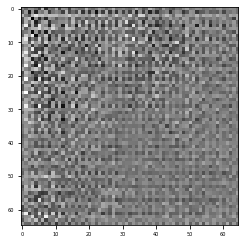

[Epoch 1/20000] [G_A loss: 4.512112] [D_B loss: 4.793369]

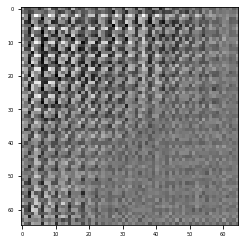

[Epoch 2/20000] [G_A loss: 1.108022] [D_B loss: 1.463164]

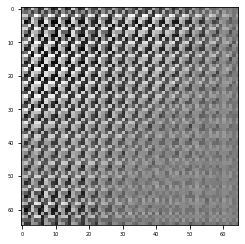

[Epoch 3/20000] [G_A loss: 0.919358] [D_B loss: 0.992090]

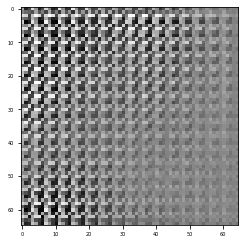

[Epoch 4/20000] [G_A loss: 0.570182] [D_B loss: 0.480727]

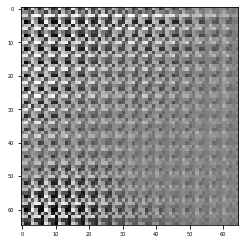

[Epoch 5/20000] [G_A loss: 0.490562] [D_B loss: 0.358547]

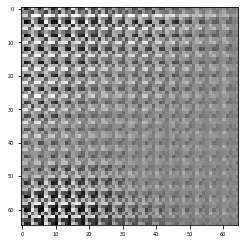

[Epoch 6/20000] [G_A loss: 0.376421] [D_B loss: 0.294773]

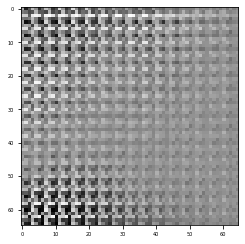

[Epoch 7/20000] [G_A loss: 0.264927] [D_B loss: 0.264277]

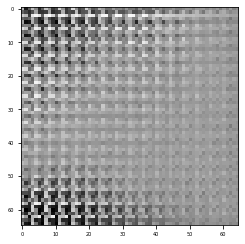

[Epoch 8/20000] [G_A loss: 0.236661] [D_B loss: 0.257060]

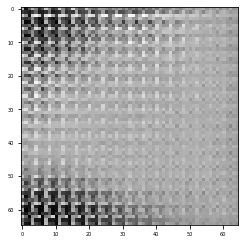

[Epoch 9/20000] [G_A loss: 0.247878] [D_B loss: 0.255282]

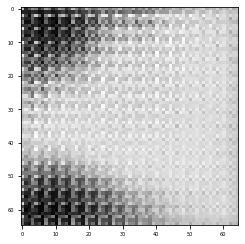

[Epoch 10/20000] [G_A loss: 0.264629] [D_B loss: 0.262126]

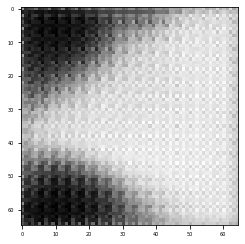

[Epoch 11/20000] [G_A loss: 0.270404] [D_B loss: 0.260209]

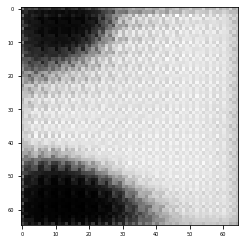

[Epoch 12/20000] [G_A loss: 0.264415] [D_B loss: 0.256638]

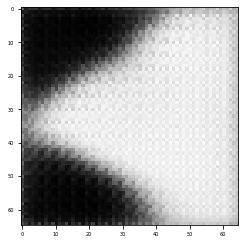

[Epoch 13/20000] [G_A loss: 0.257250] [D_B loss: 0.251138]

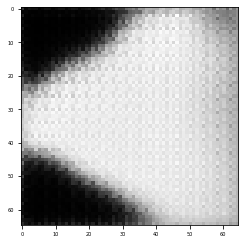

[Epoch 14/20000] [G_A loss: 0.256429] [D_B loss: 0.251212]

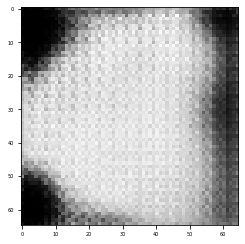

[Epoch 15/20000] [G_A loss: 0.260688] [D_B loss: 0.248507]

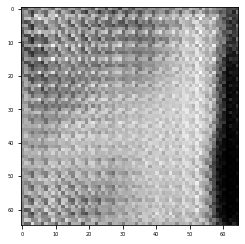

[Epoch 16/20000] [G_A loss: 0.279537] [D_B loss: 0.242746]

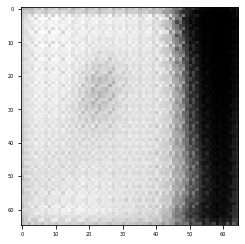

[Epoch 17/20000] [G_A loss: 0.260901] [D_B loss: 0.251351]

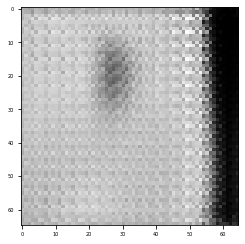

[Epoch 18/20000] [G_A loss: 0.282053] [D_B loss: 0.260834]

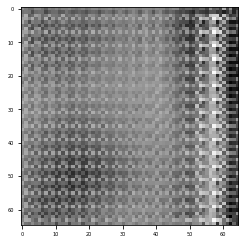

[Epoch 19/20000] [G_A loss: 0.291794] [D_B loss: 0.285591]

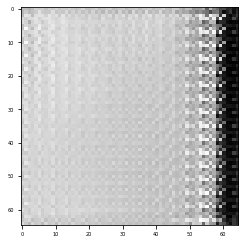

[Epoch 20/20000] [G_A loss: 0.384693] [D_B loss: 0.342393]

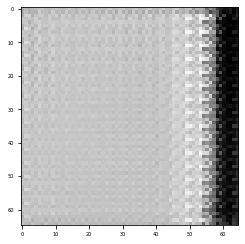

[Epoch 21/20000] [G_A loss: 0.448668] [D_B loss: 0.432644]

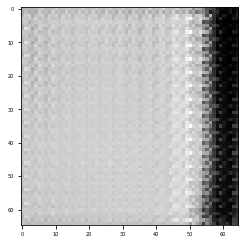

[Epoch 22/20000] [G_A loss: 0.558148] [D_B loss: 0.495729]

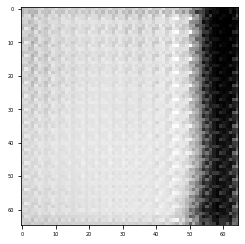

[Epoch 23/20000] [G_A loss: 0.437353] [D_B loss: 0.447387]

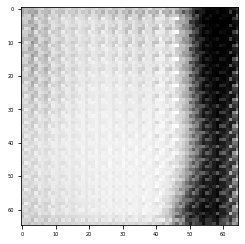

[Epoch 24/20000] [G_A loss: 0.424543] [D_B loss: 0.361171]

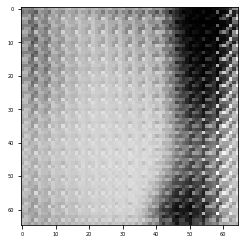

[Epoch 25/20000] [G_A loss: 0.325023] [D_B loss: 0.323057]

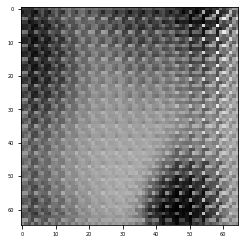

[Epoch 26/20000] [G_A loss: 0.296458] [D_B loss: 0.279067]

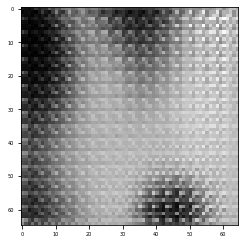

[Epoch 27/20000] [G_A loss: 0.270407] [D_B loss: 0.254602]

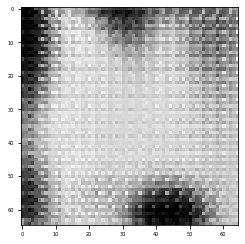

[Epoch 28/20000] [G_A loss: 0.274950] [D_B loss: 0.252347]

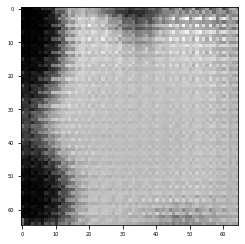

[Epoch 29/20000] [G_A loss: 0.258711] [D_B loss: 0.248467]

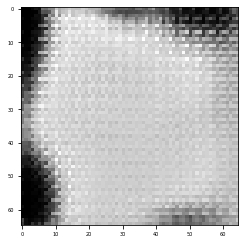

[Epoch 30/20000] [G_A loss: 0.254460] [D_B loss: 0.249560]

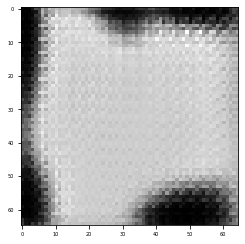

[Epoch 31/20000] [G_A loss: 0.261162] [D_B loss: 0.250625]

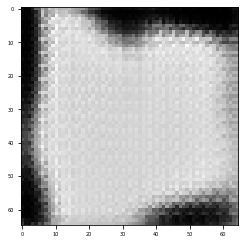

[Epoch 32/20000] [G_A loss: 0.252812] [D_B loss: 0.250242]

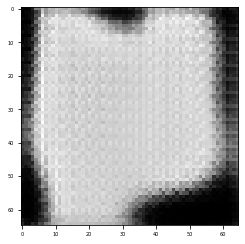

[Epoch 33/20000] [G_A loss: 0.258278] [D_B loss: 0.246753]

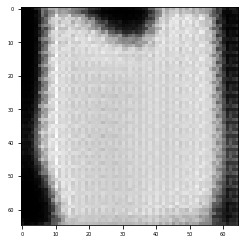

[Epoch 34/20000] [G_A loss: 0.256341] [D_B loss: 0.245937]

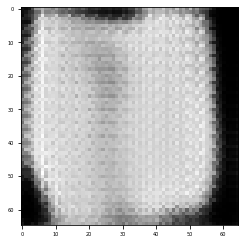

[Epoch 35/20000] [G_A loss: 0.260896] [D_B loss: 0.243670]

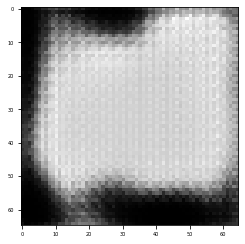

[Epoch 36/20000] [G_A loss: 0.241692] [D_B loss: 0.251549]

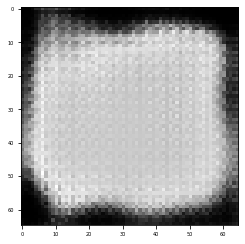

[Epoch 37/20000] [G_A loss: 0.263772] [D_B loss: 0.251257]

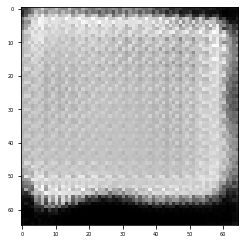

[Epoch 38/20000] [G_A loss: 0.264446] [D_B loss: 0.246637]

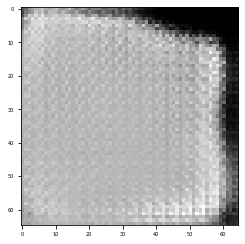

[Epoch 39/20000] [G_A loss: 0.252696] [D_B loss: 0.245865]

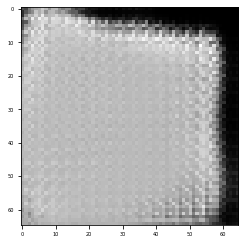

[Epoch 40/20000] [G_A loss: 0.257078] [D_B loss: 0.246254]

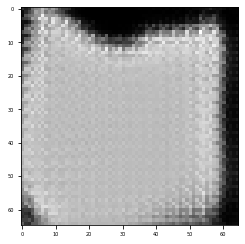

[Epoch 41/20000] [G_A loss: 0.264472] [D_B loss: 0.253255]

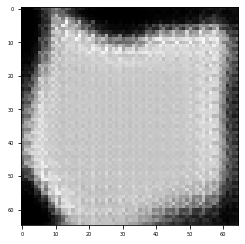

[Epoch 42/20000] [G_A loss: 0.257055] [D_B loss: 0.261039]

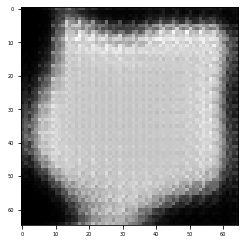

[Epoch 43/20000] [G_A loss: 0.282573] [D_B loss: 0.270039]

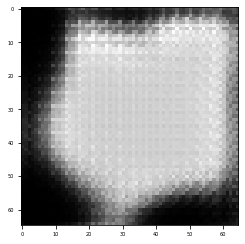

[Epoch 44/20000] [G_A loss: 0.281734] [D_B loss: 0.290666]

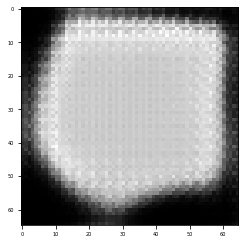

[Epoch 45/20000] [G_A loss: 0.332762] [D_B loss: 0.323713]

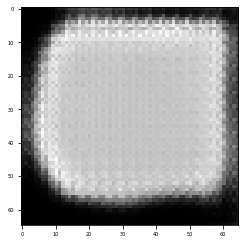

[Epoch 46/20000] [G_A loss: 0.348344] [D_B loss: 0.361091]

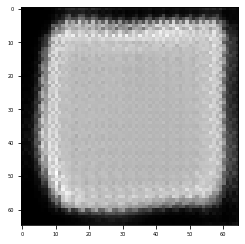

[Epoch 47/20000] [G_A loss: 0.380078] [D_B loss: 0.368772]

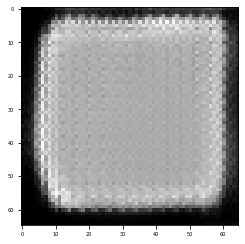

[Epoch 48/20000] [G_A loss: 0.314361] [D_B loss: 0.335547]

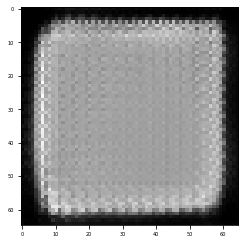

[Epoch 49/20000] [G_A loss: 0.309828] [D_B loss: 0.288957]

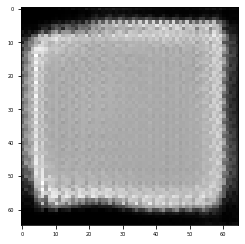

[Epoch 50/20000] [G_A loss: 0.247160] [D_B loss: 0.260242]

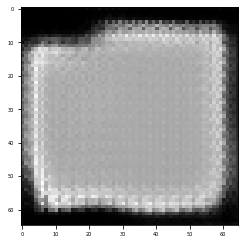

[Epoch 51/20000] [G_A loss: 0.264683] [D_B loss: 0.254981]

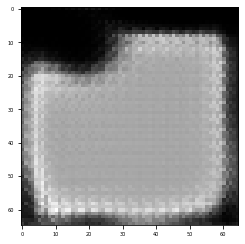

[Epoch 52/20000] [G_A loss: 0.255029] [D_B loss: 0.256442]

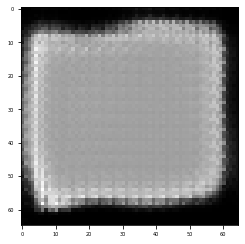

[Epoch 53/20000] [G_A loss: 0.268306] [D_B loss: 0.256292]

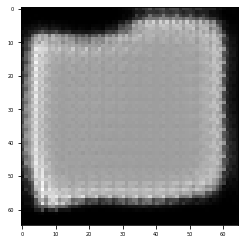

[Epoch 54/20000] [G_A loss: 0.249755] [D_B loss: 0.258132]

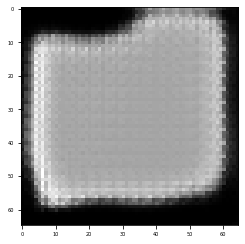

[Epoch 55/20000] [G_A loss: 0.281624] [D_B loss: 0.263650]

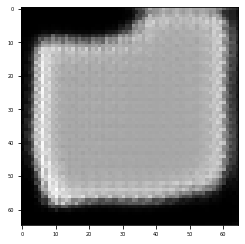

[Epoch 56/20000] [G_A loss: 0.255342] [D_B loss: 0.273068]

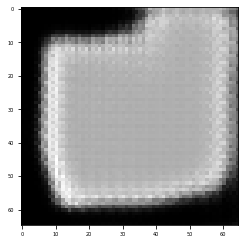

[Epoch 57/20000] [G_A loss: 0.313855] [D_B loss: 0.286185]

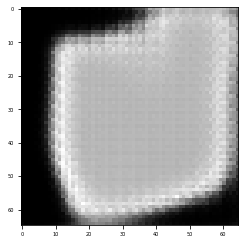

[Epoch 58/20000] [G_A loss: 0.276661] [D_B loss: 0.303709]

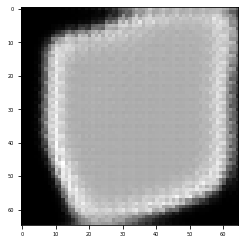

[Epoch 59/20000] [G_A loss: 0.359890] [D_B loss: 0.320149]

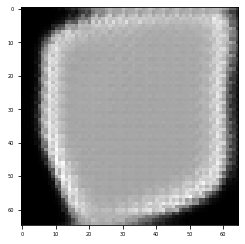

[Epoch 60/20000] [G_A loss: 0.287427] [D_B loss: 0.329297]

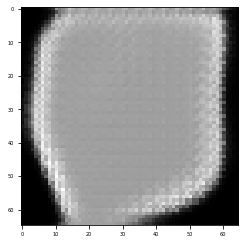

[Epoch 61/20000] [G_A loss: 0.363123] [D_B loss: 0.320307]

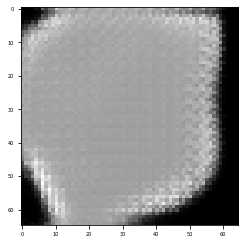

[Epoch 62/20000] [G_A loss: 0.263252] [D_B loss: 0.298833]

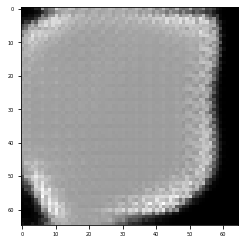

[Epoch 63/20000] [G_A loss: 0.300853] [D_B loss: 0.273010]

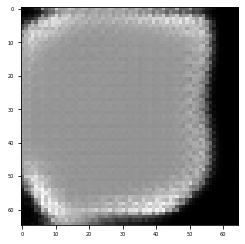

[Epoch 64/20000] [G_A loss: 0.244118] [D_B loss: 0.256489]

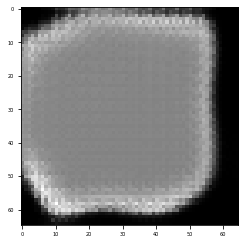

[Epoch 65/20000] [G_A loss: 0.255960] [D_B loss: 0.250365]

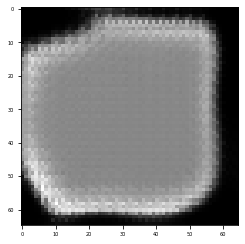

[Epoch 66/20000] [G_A loss: 0.251710] [D_B loss: 0.250324]

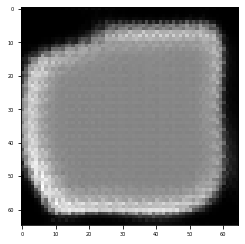

[Epoch 67/20000] [G_A loss: 0.245171] [D_B loss: 0.251092]

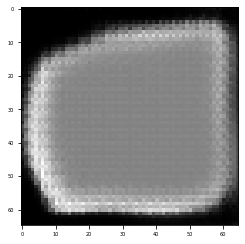

[Epoch 68/20000] [G_A loss: 0.255711] [D_B loss: 0.250720]

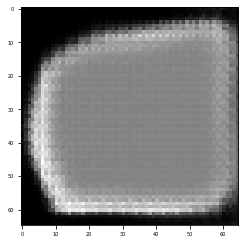

[Epoch 69/20000] [G_A loss: 0.246345] [D_B loss: 0.250201]

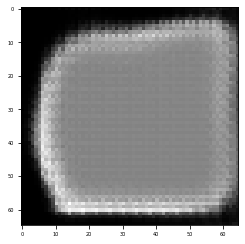

[Epoch 70/20000] [G_A loss: 0.252991] [D_B loss: 0.249794]

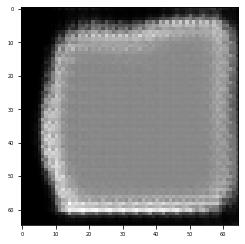

[Epoch 71/20000] [G_A loss: 0.248967] [D_B loss: 0.249625]

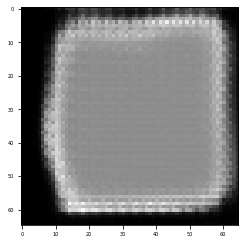

[Epoch 72/20000] [G_A loss: 0.252364] [D_B loss: 0.249096]

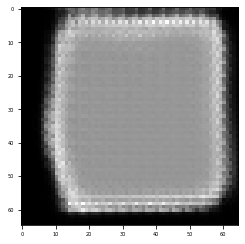

[Epoch 73/20000] [G_A loss: 0.251014] [D_B loss: 0.248538]

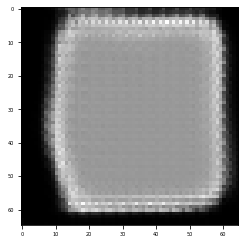

[Epoch 74/20000] [G_A loss: 0.251841] [D_B loss: 0.247945]

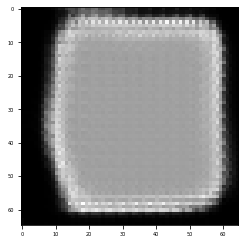

[Epoch 75/20000] [G_A loss: 0.252690] [D_B loss: 0.247393]

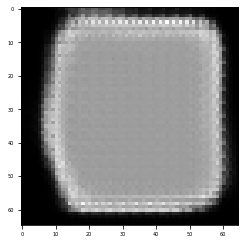

[Epoch 76/20000] [G_A loss: 0.252238] [D_B loss: 0.247118]

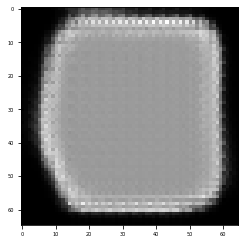

[Epoch 77/20000] [G_A loss: 0.250223] [D_B loss: 0.248148]

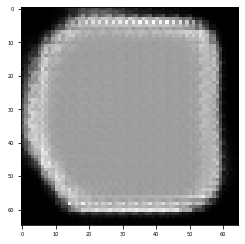

[Epoch 78/20000] [G_A loss: 0.250455] [D_B loss: 0.249053]

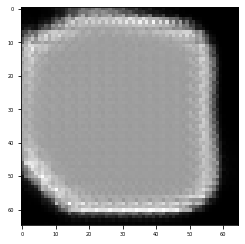

[Epoch 79/20000] [G_A loss: 0.250757] [D_B loss: 0.249623]

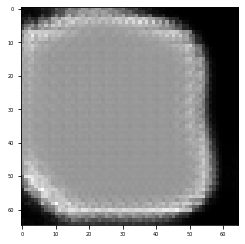

[Epoch 80/20000] [G_A loss: 0.251629] [D_B loss: 0.249028]

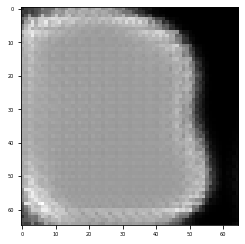

[Epoch 81/20000] [G_A loss: 0.256158] [D_B loss: 0.247321]

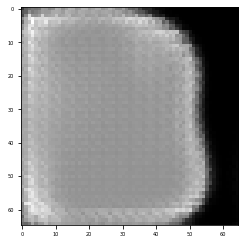

[Epoch 82/20000] [G_A loss: 0.255159] [D_B loss: 0.245554]

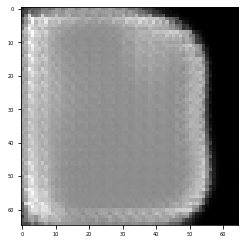

[Epoch 83/20000] [G_A loss: 0.254797] [D_B loss: 0.244460]

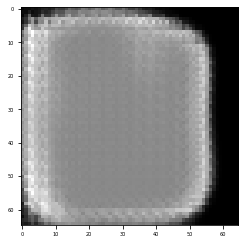

[Epoch 84/20000] [G_A loss: 0.252856] [D_B loss: 0.245518]

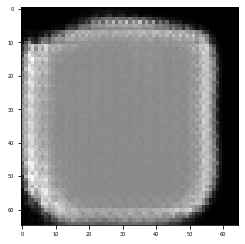

[Epoch 85/20000] [G_A loss: 0.250009] [D_B loss: 0.248862]

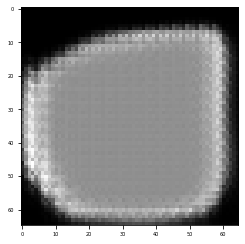

[Epoch 86/20000] [G_A loss: 0.251157] [D_B loss: 0.250486]

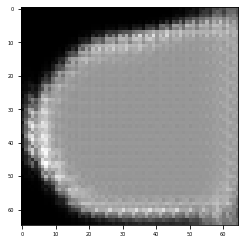

[Epoch 87/20000] [G_A loss: 0.250320] [D_B loss: 0.251820]

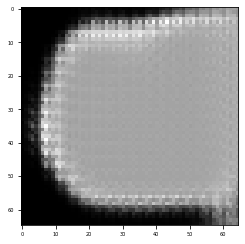

[Epoch 88/20000] [G_A loss: 0.247235] [D_B loss: 0.251648]

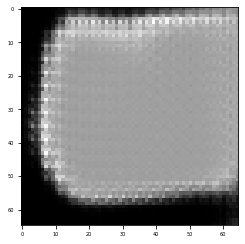

[Epoch 89/20000] [G_A loss: 0.255477] [D_B loss: 0.251710]

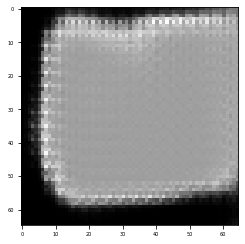

[Epoch 90/20000] [G_A loss: 0.244512] [D_B loss: 0.252247]

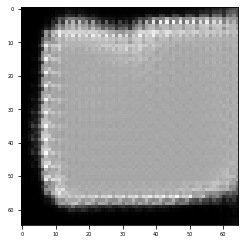

[Epoch 91/20000] [G_A loss: 0.267070] [D_B loss: 0.253666]

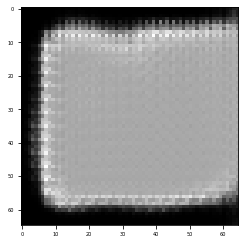

[Epoch 92/20000] [G_A loss: 0.242380] [D_B loss: 0.257530]

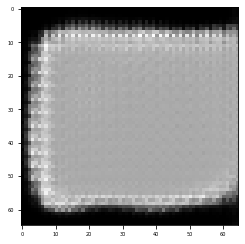

[Epoch 93/20000] [G_A loss: 0.294130] [D_B loss: 0.265867]

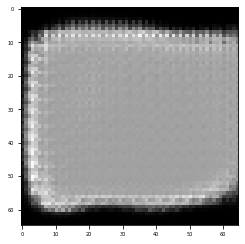

[Epoch 94/20000] [G_A loss: 0.251267] [D_B loss: 0.283405]

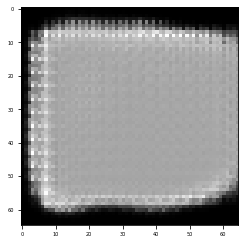

[Epoch 95/20000] [G_A loss: 0.374450] [D_B loss: 0.316412]

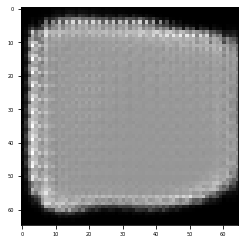

[Epoch 96/20000] [G_A loss: 0.301307] [D_B loss: 0.368865]

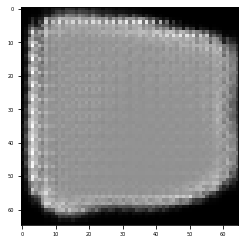

[Epoch 97/20000] [G_A loss: 0.517732] [D_B loss: 0.426808]

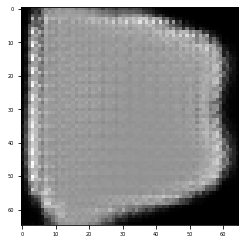

[Epoch 98/20000] [G_A loss: 0.369727] [D_B loss: 0.464721]

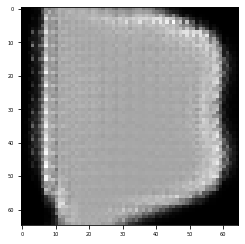

[Epoch 99/20000] [G_A loss: 0.516019] [D_B loss: 0.434813]

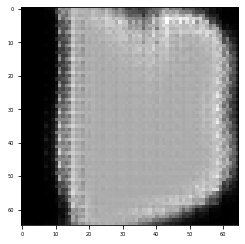

[Epoch 100/20000] [G_A loss: 0.314277] [D_B loss: 0.361159]

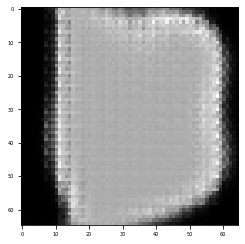

[Epoch 101/20000] [G_A loss: 0.306512] [D_B loss: 0.289958]

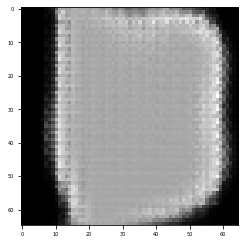

[Epoch 102/20000] [G_A loss: 0.273829] [D_B loss: 0.261116]

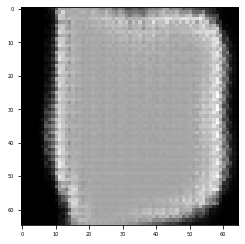

[Epoch 103/20000] [G_A loss: 0.243201] [D_B loss: 0.256485]

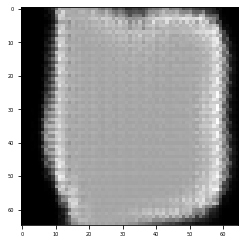

[Epoch 104/20000] [G_A loss: 0.269730] [D_B loss: 0.252786]

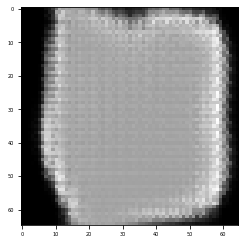

[Epoch 105/20000] [G_A loss: 0.250472] [D_B loss: 0.249368]

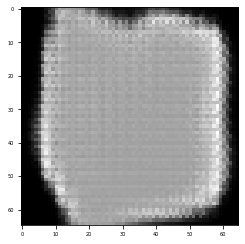

[Epoch 106/20000] [G_A loss: 0.247868] [D_B loss: 0.249492]

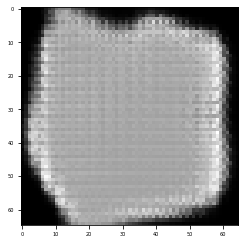

[Epoch 107/20000] [G_A loss: 0.254979] [D_B loss: 0.250363]

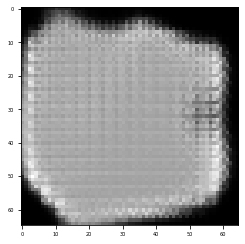

[Epoch 108/20000] [G_A loss: 0.247422] [D_B loss: 0.250427]

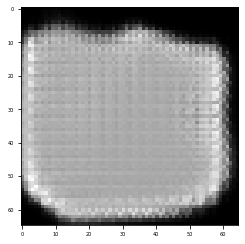

[Epoch 109/20000] [G_A loss: 0.249513] [D_B loss: 0.250163]

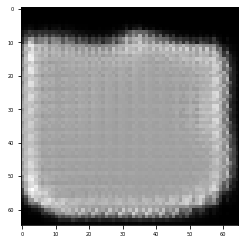

[Epoch 110/20000] [G_A loss: 0.251734] [D_B loss: 0.249555]

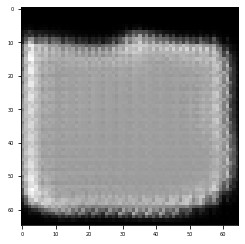

[Epoch 111/20000] [G_A loss: 0.250384] [D_B loss: 0.248880]

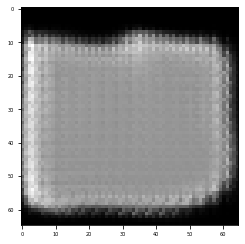

[Epoch 112/20000] [G_A loss: 0.251468] [D_B loss: 0.248360]

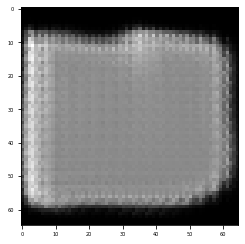

[Epoch 113/20000] [G_A loss: 0.251742] [D_B loss: 0.248136]

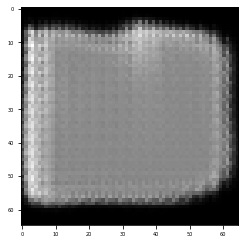

[Epoch 114/20000] [G_A loss: 0.249711] [D_B loss: 0.248657]

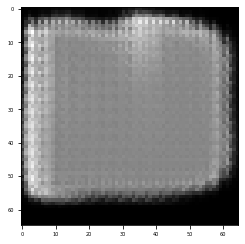

[Epoch 115/20000] [G_A loss: 0.251477] [D_B loss: 0.248758]

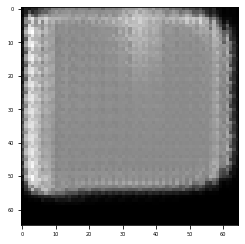

[Epoch 116/20000] [G_A loss: 0.252020] [D_B loss: 0.248044]

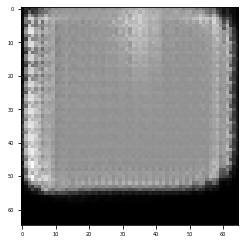

[Epoch 117/20000] [G_A loss: 0.251588] [D_B loss: 0.247778]

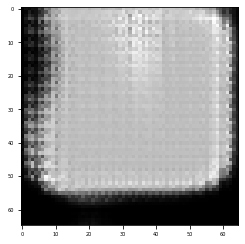

[Epoch 118/20000] [G_A loss: 0.252105] [D_B loss: 0.247941]

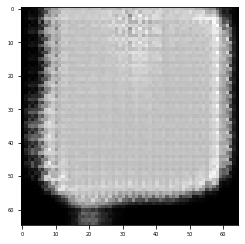

[Epoch 119/20000] [G_A loss: 0.250851] [D_B loss: 0.248577]

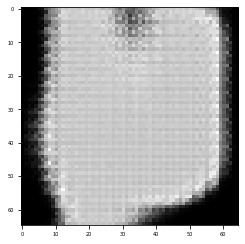

[Epoch 120/20000] [G_A loss: 0.251142] [D_B loss: 0.248560]

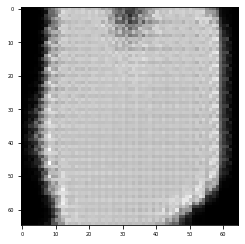

[Epoch 121/20000] [G_A loss: 0.251312] [D_B loss: 0.248229]

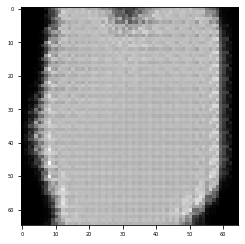

[Epoch 122/20000] [G_A loss: 0.251361] [D_B loss: 0.247867]

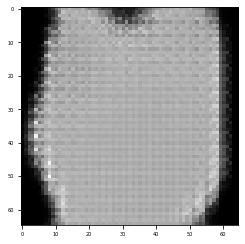

[Epoch 123/20000] [G_A loss: 0.251871] [D_B loss: 0.247540]

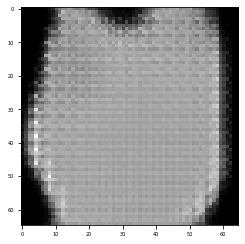

[Epoch 124/20000] [G_A loss: 0.251730] [D_B loss: 0.247424]

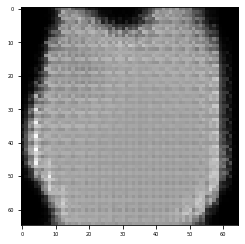

[Epoch 125/20000] [G_A loss: 0.251299] [D_B loss: 0.247635]

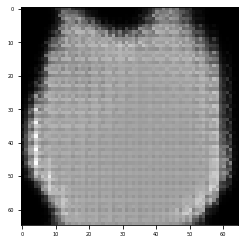

[Epoch 126/20000] [G_A loss: 0.251427] [D_B loss: 0.248078]

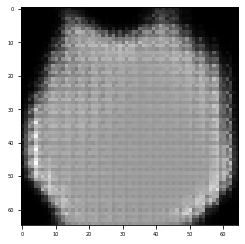

[Epoch 127/20000] [G_A loss: 0.250963] [D_B loss: 0.248464]

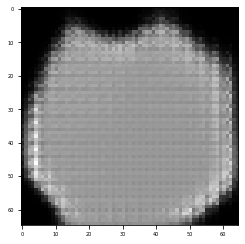

[Epoch 128/20000] [G_A loss: 0.252130] [D_B loss: 0.248462]

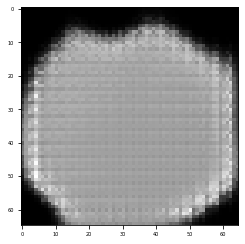

[Epoch 129/20000] [G_A loss: 0.250852] [D_B loss: 0.248401]

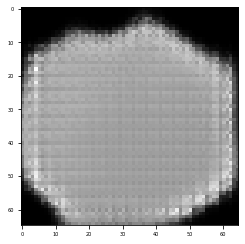

[Epoch 130/20000] [G_A loss: 0.251726] [D_B loss: 0.248658]

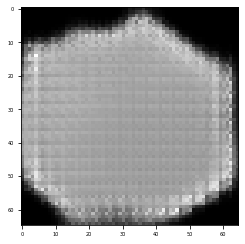

[Epoch 131/20000] [G_A loss: 0.250905] [D_B loss: 0.248673]

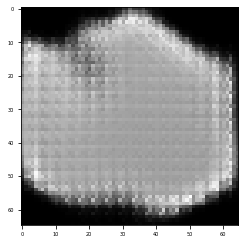

[Epoch 132/20000] [G_A loss: 0.251549] [D_B loss: 0.249190]

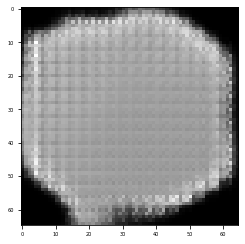

[Epoch 133/20000] [G_A loss: 0.250086] [D_B loss: 0.249933]

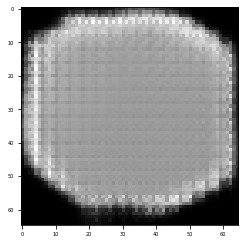

[Epoch 134/20000] [G_A loss: 0.254474] [D_B loss: 0.250687]

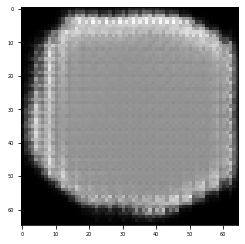

[Epoch 135/20000] [G_A loss: 0.250308] [D_B loss: 0.252119]

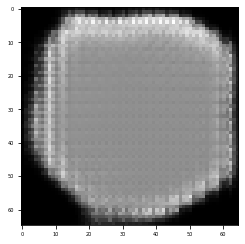

[Epoch 136/20000] [G_A loss: 0.260669] [D_B loss: 0.254818]

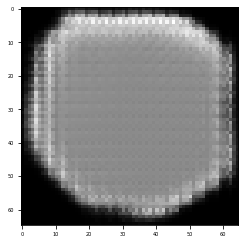

[Epoch 137/20000] [G_A loss: 0.256900] [D_B loss: 0.259820]

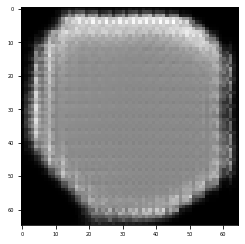

[Epoch 138/20000] [G_A loss: 0.276241] [D_B loss: 0.268385]

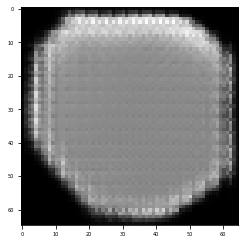

[Epoch 139/20000] [G_A loss: 0.276188] [D_B loss: 0.280686]

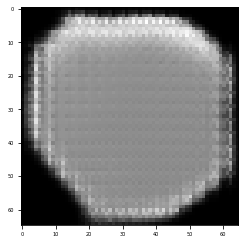

[Epoch 140/20000] [G_A loss: 0.303886] [D_B loss: 0.293681]

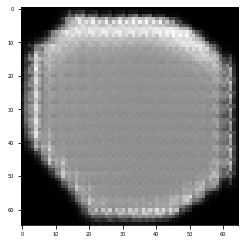

[Epoch 141/20000] [G_A loss: 0.294018] [D_B loss: 0.298333]

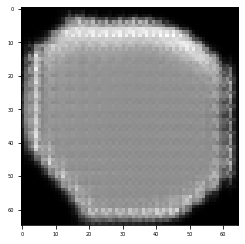

[Epoch 142/20000] [G_A loss: 0.298015] [D_B loss: 0.291734]

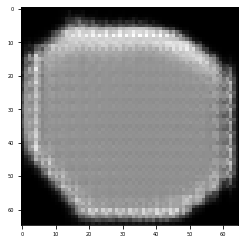

[Epoch 143/20000] [G_A loss: 0.280919] [D_B loss: 0.277582]

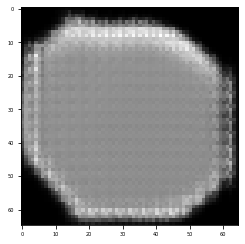

[Epoch 144/20000] [G_A loss: 0.263010] [D_B loss: 0.264833]

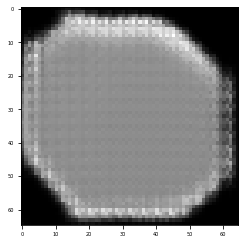

[Epoch 145/20000] [G_A loss: 0.262761] [D_B loss: 0.257580]

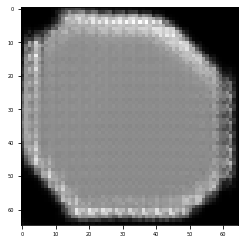

[Epoch 146/20000] [G_A loss: 0.258580] [D_B loss: 0.254641]

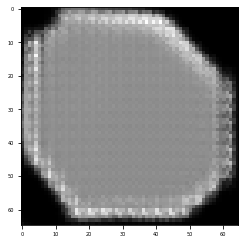

[Epoch 147/20000] [G_A loss: 0.247322] [D_B loss: 0.253021]

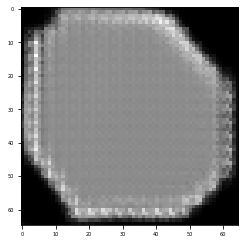

[Epoch 148/20000] [G_A loss: 0.265715] [D_B loss: 0.251657]

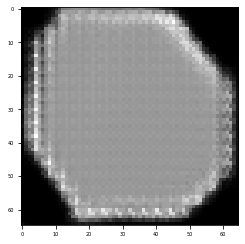

[Epoch 149/20000] [G_A loss: 0.239599] [D_B loss: 0.250606]

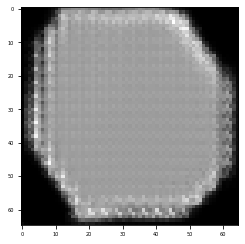

[Epoch 150/20000] [G_A loss: 0.264200] [D_B loss: 0.249935]

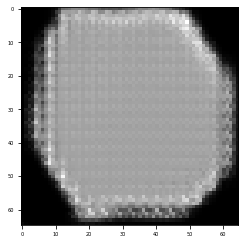

[Epoch 151/20000] [G_A loss: 0.242239] [D_B loss: 0.249479]

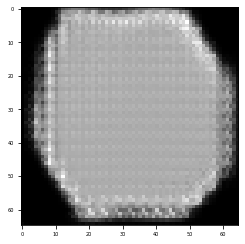

[Epoch 152/20000] [G_A loss: 0.258763] [D_B loss: 0.249134]

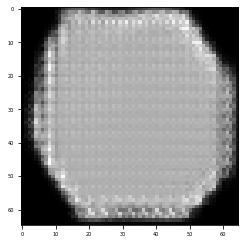

[Epoch 153/20000] [G_A loss: 0.246058] [D_B loss: 0.249029]

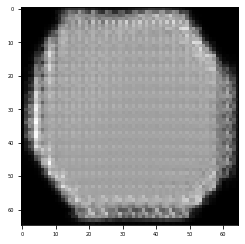

[Epoch 154/20000] [G_A loss: 0.254980] [D_B loss: 0.249106]

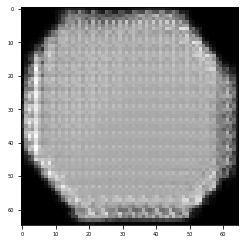

[Epoch 155/20000] [G_A loss: 0.247693] [D_B loss: 0.249125]

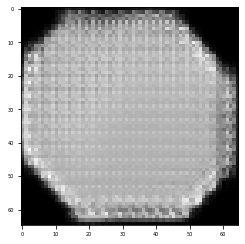

[Epoch 156/20000] [G_A loss: 0.253432] [D_B loss: 0.249103]

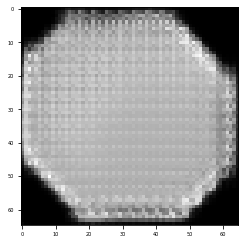

[Epoch 157/20000] [G_A loss: 0.248372] [D_B loss: 0.249092]

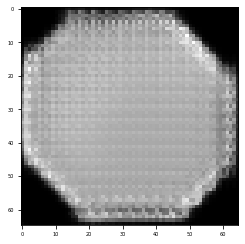

[Epoch 158/20000] [G_A loss: 0.253173] [D_B loss: 0.249094]

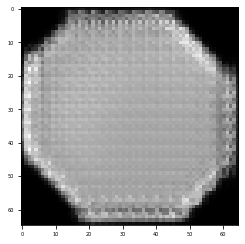

[Epoch 159/20000] [G_A loss: 0.248506] [D_B loss: 0.249104]

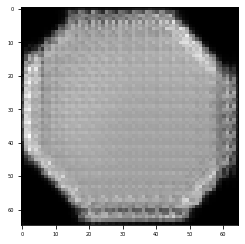

[Epoch 160/20000] [G_A loss: 0.253540] [D_B loss: 0.249123]

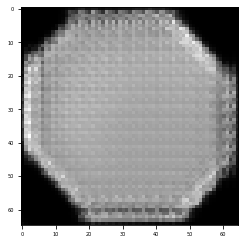

[Epoch 161/20000] [G_A loss: 0.248224] [D_B loss: 0.249146]

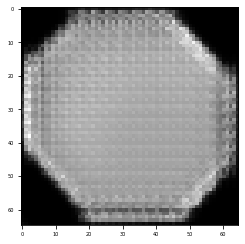

[Epoch 162/20000] [G_A loss: 0.254142] [D_B loss: 0.249173]

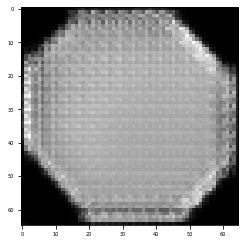

[Epoch 163/20000] [G_A loss: 0.247768] [D_B loss: 0.249230]

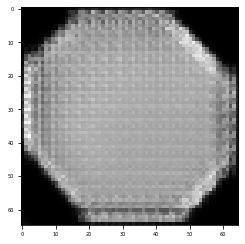

[Epoch 164/20000] [G_A loss: 0.255294] [D_B loss: 0.249353]

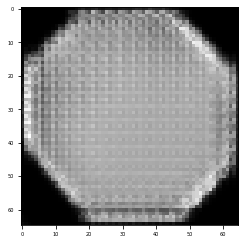

[Epoch 165/20000] [G_A loss: 0.246839] [D_B loss: 0.249562]

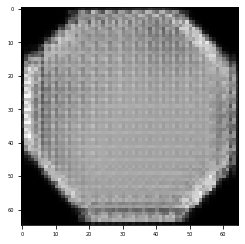

[Epoch 166/20000] [G_A loss: 0.257266] [D_B loss: 0.249828]

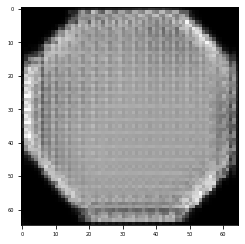

[Epoch 167/20000] [G_A loss: 0.245875] [D_B loss: 0.250301]

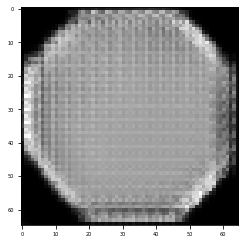

[Epoch 168/20000] [G_A loss: 0.260931] [D_B loss: 0.251091]

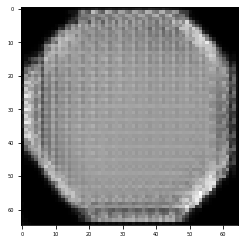

[Epoch 169/20000] [G_A loss: 0.245211] [D_B loss: 0.252419]

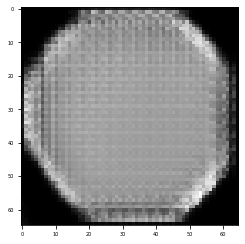

[Epoch 170/20000] [G_A loss: 0.267947] [D_B loss: 0.254623]

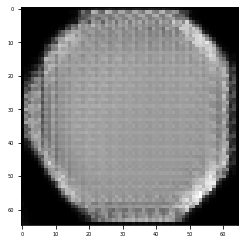

[Epoch 171/20000] [G_A loss: 0.247112] [D_B loss: 0.258264]

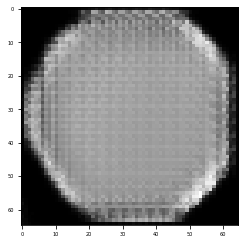

[Epoch 172/20000] [G_A loss: 0.282474] [D_B loss: 0.264218]

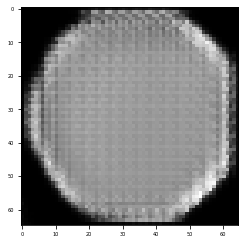

[Epoch 173/20000] [G_A loss: 0.257276] [D_B loss: 0.274264]

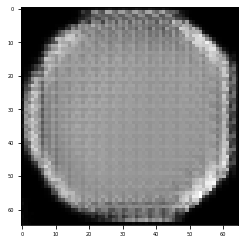

[Epoch 174/20000] [G_A loss: 0.313994] [D_B loss: 0.289532]

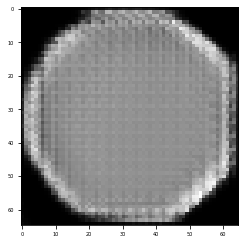

[Epoch 175/20000] [G_A loss: 0.288927] [D_B loss: 0.312401]

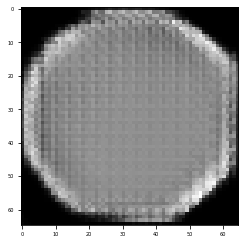

[Epoch 176/20000] [G_A loss: 0.364193] [D_B loss: 0.336427]

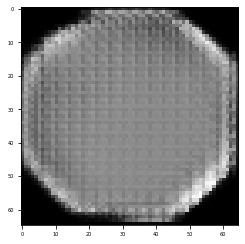

[Epoch 177/20000] [G_A loss: 0.330489] [D_B loss: 0.352318]

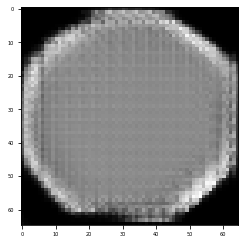

[Epoch 178/20000] [G_A loss: 0.357986] [D_B loss: 0.339154]

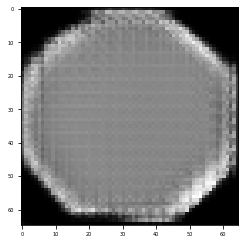

[Epoch 179/20000] [G_A loss: 0.304927] [D_B loss: 0.309969]

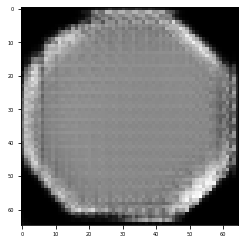

[Epoch 180/20000] [G_A loss: 0.279916] [D_B loss: 0.280311]

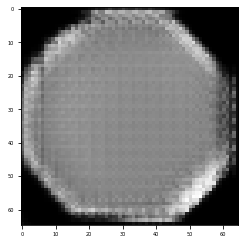

[Epoch 181/20000] [G_A loss: 0.271180] [D_B loss: 0.262588]

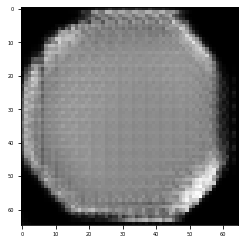

[Epoch 182/20000] [G_A loss: 0.250689] [D_B loss: 0.253719]

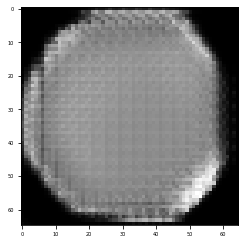

[Epoch 183/20000] [G_A loss: 0.252719] [D_B loss: 0.250341]

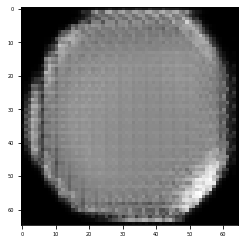

[Epoch 184/20000] [G_A loss: 0.255499] [D_B loss: 0.249345]

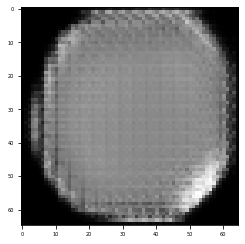

[Epoch 185/20000] [G_A loss: 0.244728] [D_B loss: 0.249055]

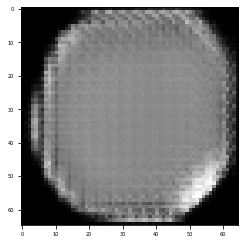

[Epoch 186/20000] [G_A loss: 0.258285] [D_B loss: 0.248937]

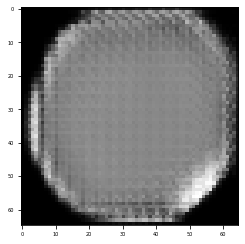

[Epoch 187/20000] [G_A loss: 0.244739] [D_B loss: 0.248793]

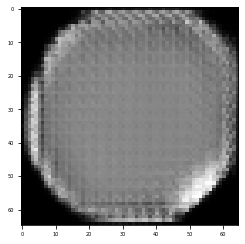

[Epoch 188/20000] [G_A loss: 0.255530] [D_B loss: 0.248624]

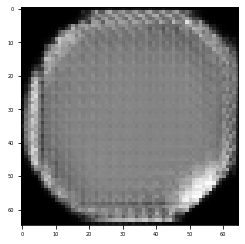

[Epoch 189/20000] [G_A loss: 0.247473] [D_B loss: 0.248526]

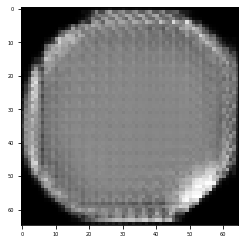

[Epoch 190/20000] [G_A loss: 0.252805] [D_B loss: 0.248535]

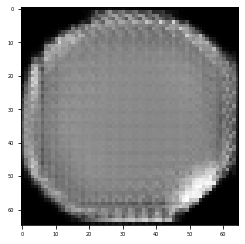

[Epoch 191/20000] [G_A loss: 0.249200] [D_B loss: 0.248587]

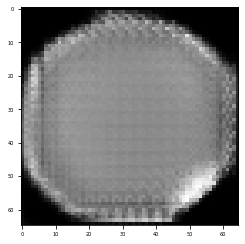

[Epoch 192/20000] [G_A loss: 0.251889] [D_B loss: 0.248598]

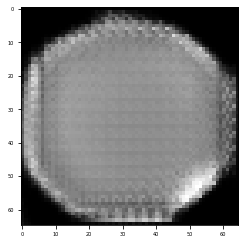

[Epoch 193/20000] [G_A loss: 0.249906] [D_B loss: 0.248502]

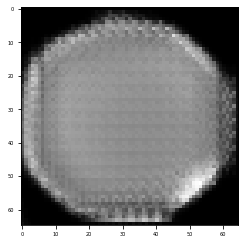

[Epoch 194/20000] [G_A loss: 0.251786] [D_B loss: 0.248387]

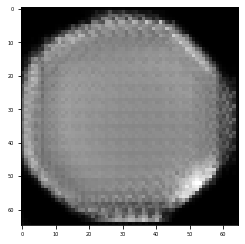

[Epoch 195/20000] [G_A loss: 0.250099] [D_B loss: 0.248322]

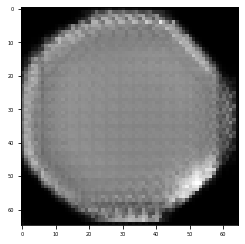

[Epoch 196/20000] [G_A loss: 0.251645] [D_B loss: 0.248363]

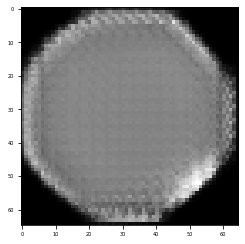

[Epoch 197/20000] [G_A loss: 0.250114] [D_B loss: 0.248493]

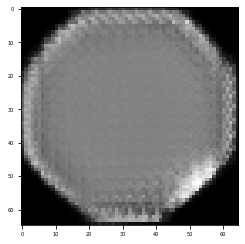

[Epoch 198/20000] [G_A loss: 0.251476] [D_B loss: 0.248548]

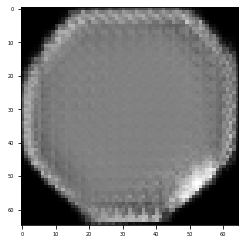

[Epoch 199/20000] [G_A loss: 0.250107] [D_B loss: 0.248488]

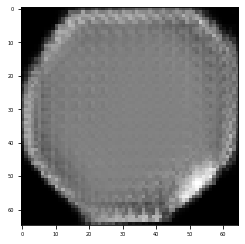

[Epoch 200/20000] [G_A loss: 0.251484] [D_B loss: 0.248356]

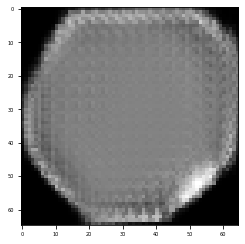

[Epoch 201/20000] [G_A loss: 0.250229] [D_B loss: 0.248266]

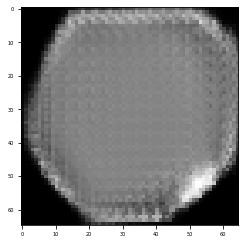

[Epoch 202/20000] [G_A loss: 0.251717] [D_B loss: 0.248223]

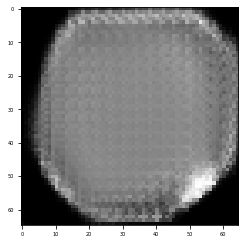

[Epoch 203/20000] [G_A loss: 0.249852] [D_B loss: 0.248374]

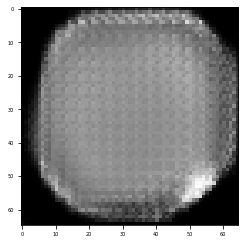

[Epoch 204/20000] [G_A loss: 0.251636] [D_B loss: 0.248668]

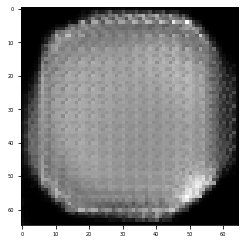

[Epoch 205/20000] [G_A loss: 0.249523] [D_B loss: 0.248768]

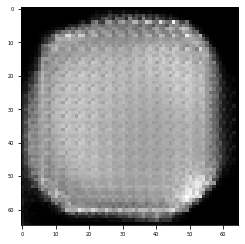

[Epoch 206/20000] [G_A loss: 0.252351] [D_B loss: 0.248464]

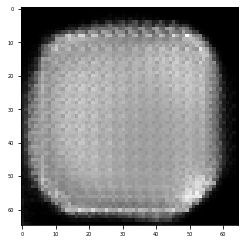

[Epoch 207/20000] [G_A loss: 0.249325] [D_B loss: 0.248186]

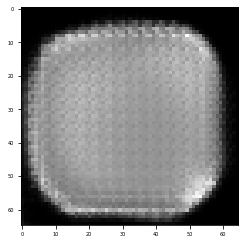

[Epoch 208/20000] [G_A loss: 0.253125] [D_B loss: 0.248174]

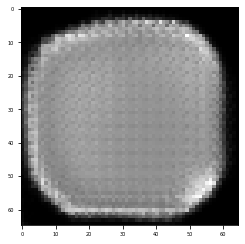

[Epoch 209/20000] [G_A loss: 0.248612] [D_B loss: 0.248284]

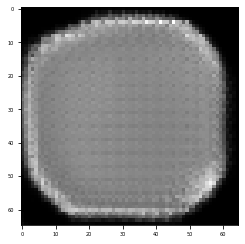

[Epoch 210/20000] [G_A loss: 0.253730] [D_B loss: 0.248349]

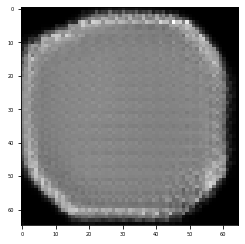

[Epoch 211/20000] [G_A loss: 0.247016] [D_B loss: 0.248431]

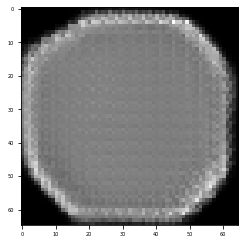

[Epoch 212/20000] [G_A loss: 0.255437] [D_B loss: 0.248399]

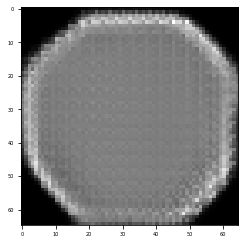

[Epoch 213/20000] [G_A loss: 0.245137] [D_B loss: 0.248248]

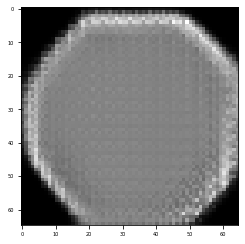

[Epoch 214/20000] [G_A loss: 0.258344] [D_B loss: 0.248282]

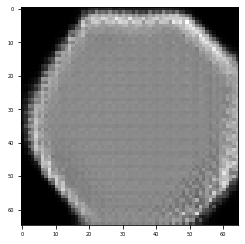

[Epoch 215/20000] [G_A loss: 0.241371] [D_B loss: 0.248604]

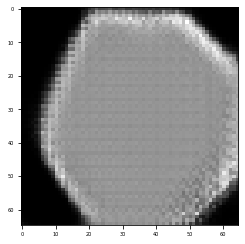

[Epoch 216/20000] [G_A loss: 0.264294] [D_B loss: 0.248660]

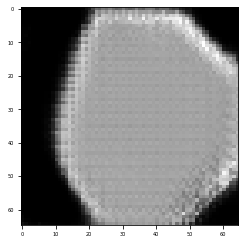

[Epoch 217/20000] [G_A loss: 0.236018] [D_B loss: 0.248284]

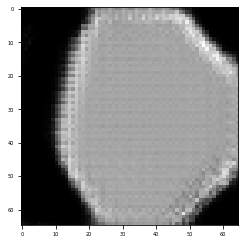

[Epoch 218/20000] [G_A loss: 0.274790] [D_B loss: 0.248526]

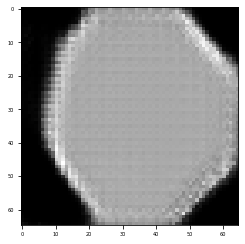

[Epoch 219/20000] [G_A loss: 0.223628] [D_B loss: 0.250158]

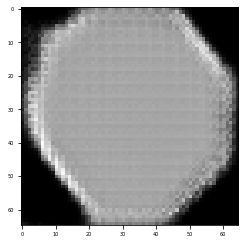

[Epoch 220/20000] [G_A loss: 0.294238] [D_B loss: 0.252234]

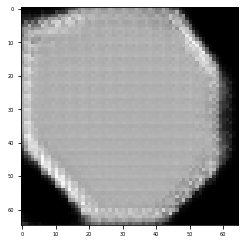

[Epoch 221/20000] [G_A loss: 0.203314] [D_B loss: 0.255410]

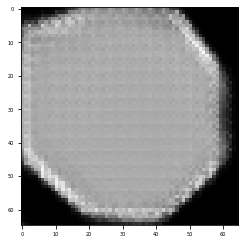

[Epoch 222/20000] [G_A loss: 0.335464] [D_B loss: 0.260976]

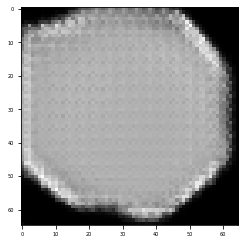

[Epoch 223/20000] [G_A loss: 0.174185] [D_B loss: 0.270603]

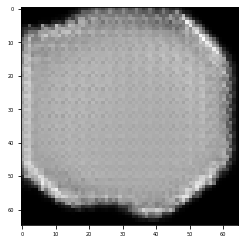

[Epoch 224/20000] [G_A loss: 0.420137] [D_B loss: 0.286495]

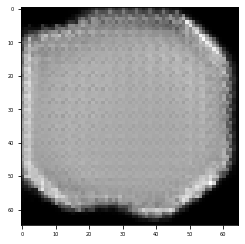

[Epoch 225/20000] [G_A loss: 0.139505] [D_B loss: 0.310629]

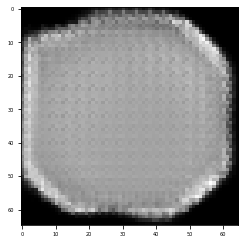

[Epoch 226/20000] [G_A loss: 0.564239] [D_B loss: 0.341796]

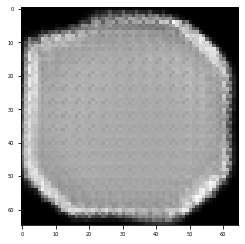

[Epoch 227/20000] [G_A loss: 0.109992] [D_B loss: 0.371382]

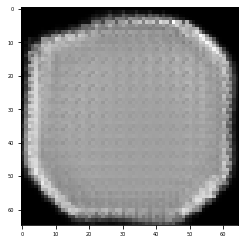

[Epoch 228/20000] [G_A loss: 0.678253] [D_B loss: 0.386138]

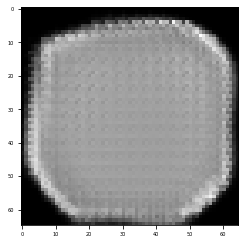

[Epoch 229/20000] [G_A loss: 0.095008] [D_B loss: 0.376788]

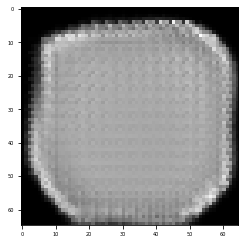

[Epoch 230/20000] [G_A loss: 0.596624] [D_B loss: 0.348880]

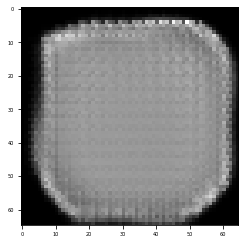

[Epoch 231/20000] [G_A loss: 0.138420] [D_B loss: 0.319442]

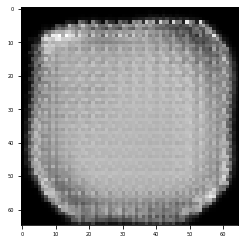

[Epoch 232/20000] [G_A loss: 0.423173] [D_B loss: 0.298954]

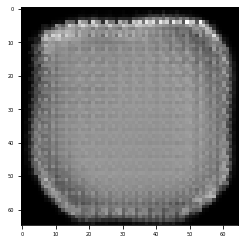

[Epoch 233/20000] [G_A loss: 0.214440] [D_B loss: 0.281058]

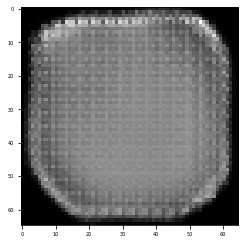

[Epoch 234/20000] [G_A loss: 0.299418] [D_B loss: 0.264022]

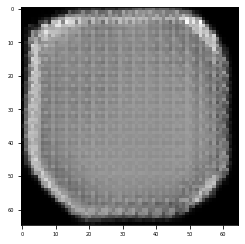

[Epoch 235/20000] [G_A loss: 0.247222] [D_B loss: 0.253085]

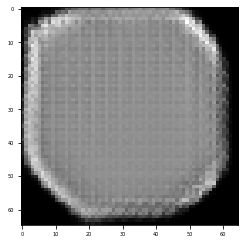

[Epoch 236/20000] [G_A loss: 0.248130] [D_B loss: 0.249510]

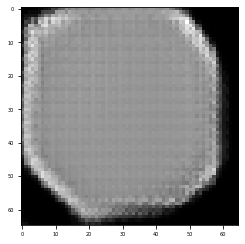

[Epoch 237/20000] [G_A loss: 0.261297] [D_B loss: 0.249332]

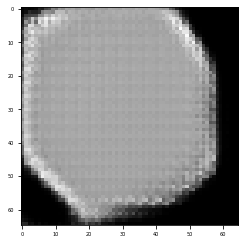

[Epoch 238/20000] [G_A loss: 0.240497] [D_B loss: 0.249116]

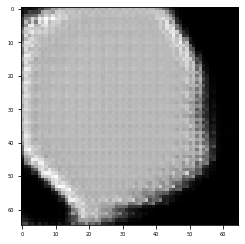

[Epoch 239/20000] [G_A loss: 0.261446] [D_B loss: 0.248115]

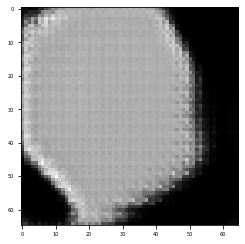

[Epoch 240/20000] [G_A loss: 0.245293] [D_B loss: 0.247237]

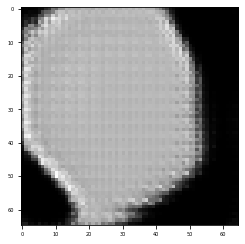

[Epoch 241/20000] [G_A loss: 0.256448] [D_B loss: 0.247100]

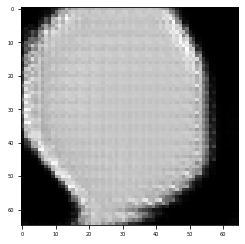

[Epoch 242/20000] [G_A loss: 0.248785] [D_B loss: 0.247783]

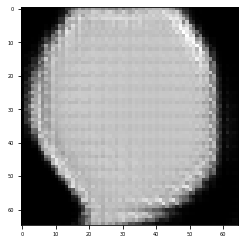

[Epoch 243/20000] [G_A loss: 0.251784] [D_B loss: 0.248717]

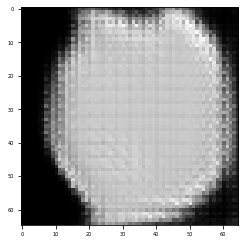

[Epoch 244/20000] [G_A loss: 0.249895] [D_B loss: 0.248869]

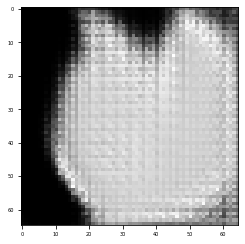

[Epoch 245/20000] [G_A loss: 0.250072] [D_B loss: 0.248913]

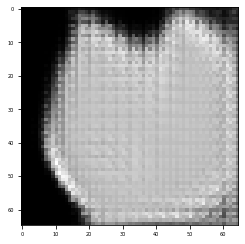

[Epoch 246/20000] [G_A loss: 0.251662] [D_B loss: 0.248926]

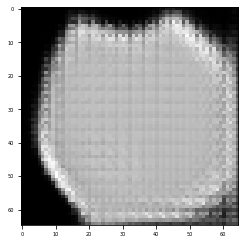

[Epoch 247/20000] [G_A loss: 0.249986] [D_B loss: 0.248702]

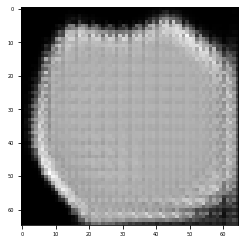

[Epoch 248/20000] [G_A loss: 0.251379] [D_B loss: 0.248523]

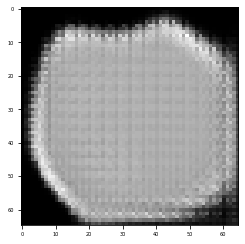

[Epoch 249/20000] [G_A loss: 0.250470] [D_B loss: 0.248428]

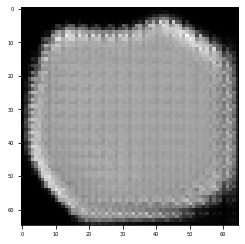

[Epoch 250/20000] [G_A loss: 0.251382] [D_B loss: 0.248364]

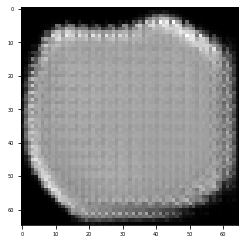

[Epoch 251/20000] [G_A loss: 0.250781] [D_B loss: 0.248333]

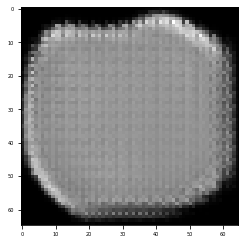

[Epoch 252/20000] [G_A loss: 0.251275] [D_B loss: 0.248314]

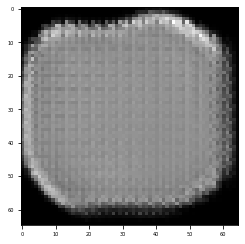

[Epoch 253/20000] [G_A loss: 0.251061] [D_B loss: 0.248226]

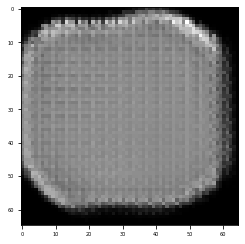

[Epoch 254/20000] [G_A loss: 0.251370] [D_B loss: 0.248067]

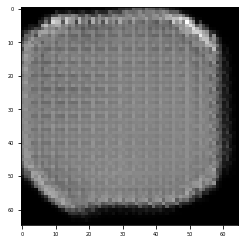

[Epoch 255/20000] [G_A loss: 0.251467] [D_B loss: 0.247778]

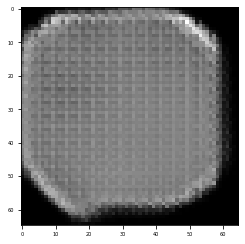

[Epoch 256/20000] [G_A loss: 0.251203] [D_B loss: 0.247722]

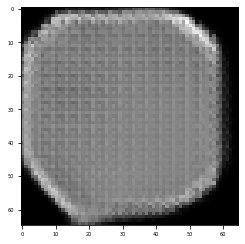

[Epoch 257/20000] [G_A loss: 0.251787] [D_B loss: 0.247731]

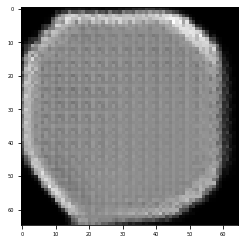

[Epoch 258/20000] [G_A loss: 0.250918] [D_B loss: 0.247893]

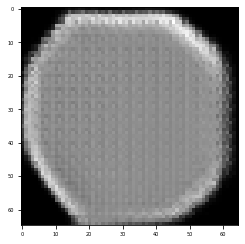

[Epoch 259/20000] [G_A loss: 0.250829] [D_B loss: 0.248378]

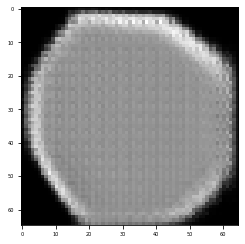

[Epoch 260/20000] [G_A loss: 0.250013] [D_B loss: 0.248943]

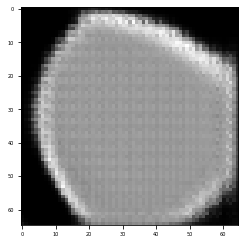

[Epoch 261/20000] [G_A loss: 0.250477] [D_B loss: 0.249181]

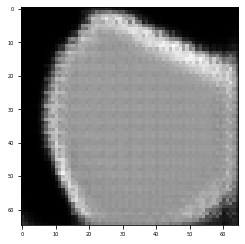

[Epoch 262/20000] [G_A loss: 0.251089] [D_B loss: 0.248593]

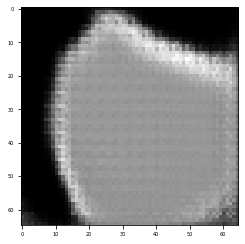

[Epoch 263/20000] [G_A loss: 0.251117] [D_B loss: 0.247915]

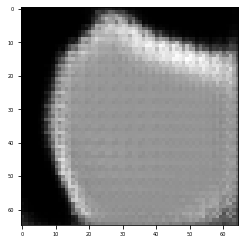

[Epoch 264/20000] [G_A loss: 0.252009] [D_B loss: 0.247464]

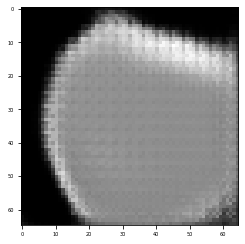

[Epoch 265/20000] [G_A loss: 0.251701] [D_B loss: 0.247231]

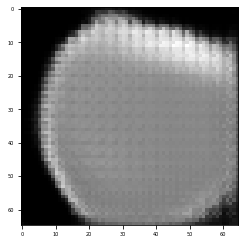

[Epoch 266/20000] [G_A loss: 0.252167] [D_B loss: 0.247296]

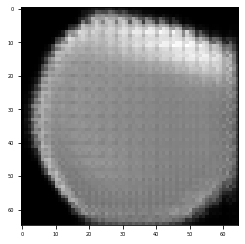

[Epoch 267/20000] [G_A loss: 0.251198] [D_B loss: 0.247741]

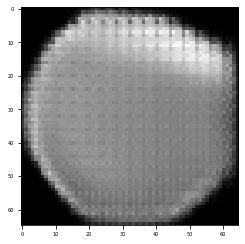

[Epoch 268/20000] [G_A loss: 0.251129] [D_B loss: 0.248347]

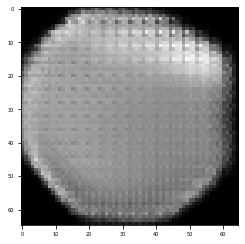

[Epoch 269/20000] [G_A loss: 0.250024] [D_B loss: 0.248926]

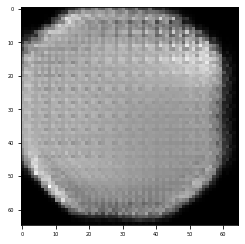

[Epoch 270/20000] [G_A loss: 0.251120] [D_B loss: 0.248983]

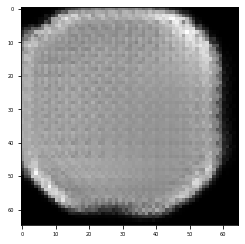

[Epoch 271/20000] [G_A loss: 0.249826] [D_B loss: 0.248788]

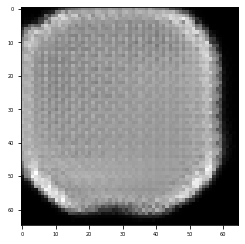

[Epoch 272/20000] [G_A loss: 0.251448] [D_B loss: 0.248462]

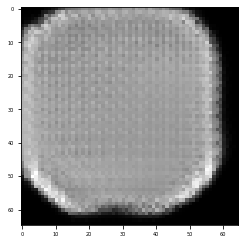

[Epoch 273/20000] [G_A loss: 0.250446] [D_B loss: 0.248095]

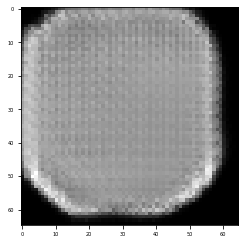

[Epoch 274/20000] [G_A loss: 0.252040] [D_B loss: 0.247784]

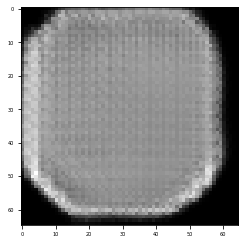

[Epoch 275/20000] [G_A loss: 0.250775] [D_B loss: 0.247683]

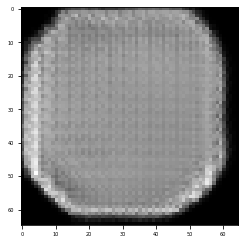

[Epoch 276/20000] [G_A loss: 0.251848] [D_B loss: 0.247902]

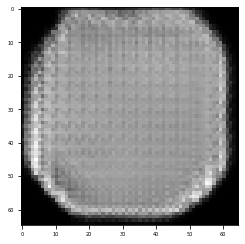

[Epoch 277/20000] [G_A loss: 0.250165] [D_B loss: 0.248315]

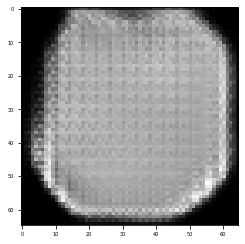

[Epoch 278/20000] [G_A loss: 0.251670] [D_B loss: 0.248451]

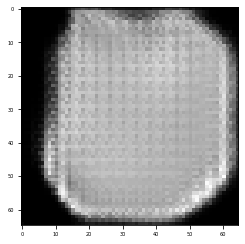

[Epoch 279/20000] [G_A loss: 0.250216] [D_B loss: 0.248398]

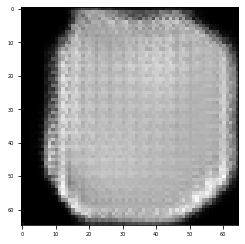

[Epoch 280/20000] [G_A loss: 0.252164] [D_B loss: 0.248315]

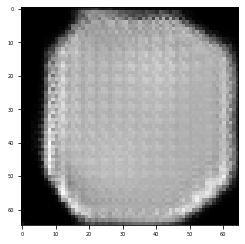

[Epoch 281/20000] [G_A loss: 0.250420] [D_B loss: 0.248172]

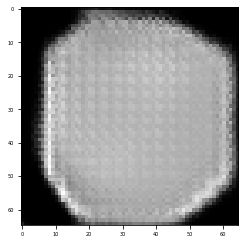

[Epoch 282/20000] [G_A loss: 0.252132] [D_B loss: 0.248300]

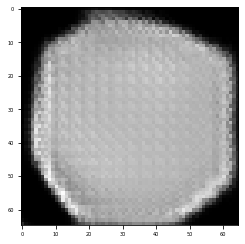

[Epoch 283/20000] [G_A loss: 0.250025] [D_B loss: 0.248617]

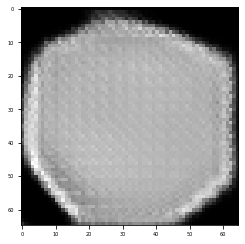

[Epoch 284/20000] [G_A loss: 0.252668] [D_B loss: 0.248728]

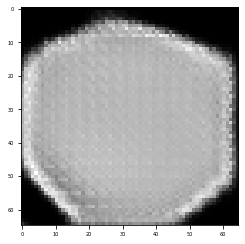

[Epoch 285/20000] [G_A loss: 0.250159] [D_B loss: 0.248810]

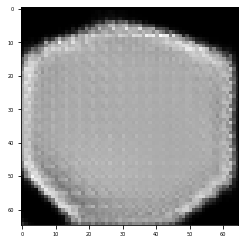

[Epoch 286/20000] [G_A loss: 0.254099] [D_B loss: 0.249023]

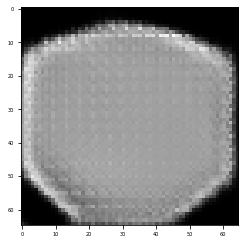

[Epoch 287/20000] [G_A loss: 0.251157] [D_B loss: 0.249536]

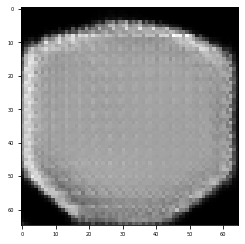

[Epoch 288/20000] [G_A loss: 0.255971] [D_B loss: 0.250702]

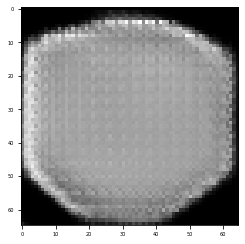

[Epoch 289/20000] [G_A loss: 0.254127] [D_B loss: 0.252948]

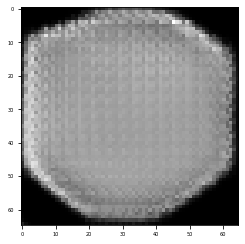

[Epoch 290/20000] [G_A loss: 0.260186] [D_B loss: 0.256551]

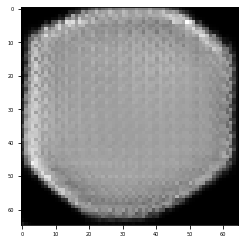

[Epoch 291/20000] [G_A loss: 0.264408] [D_B loss: 0.262479]

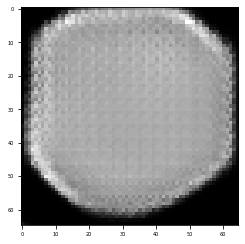

[Epoch 292/20000] [G_A loss: 0.273559] [D_B loss: 0.272271]

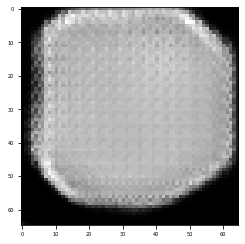

[Epoch 293/20000] [G_A loss: 0.292587] [D_B loss: 0.287182]

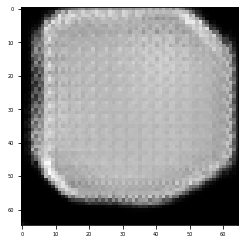

[Epoch 294/20000] [G_A loss: 0.308132] [D_B loss: 0.309307]

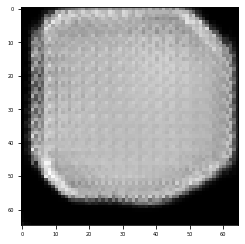

[Epoch 295/20000] [G_A loss: 0.344611] [D_B loss: 0.333724]

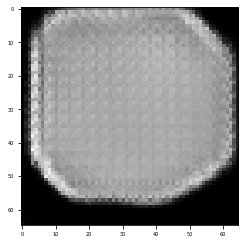

[Epoch 296/20000] [G_A loss: 0.349440] [D_B loss: 0.355510]

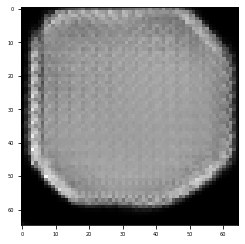

[Epoch 297/20000] [G_A loss: 0.377358] [D_B loss: 0.359132]

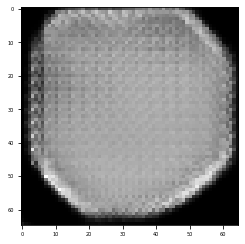

[Epoch 298/20000] [G_A loss: 0.322476] [D_B loss: 0.341509]

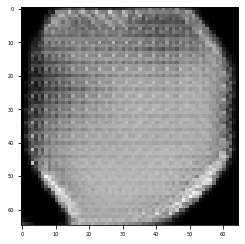

[Epoch 299/20000] [G_A loss: 0.341016] [D_B loss: 0.308693]

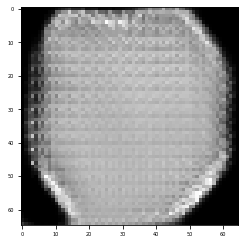

[Epoch 300/20000] [G_A loss: 0.245779] [D_B loss: 0.278796]

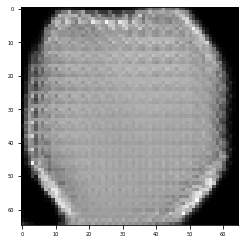

[Epoch 301/20000] [G_A loss: 0.303965] [D_B loss: 0.261268]

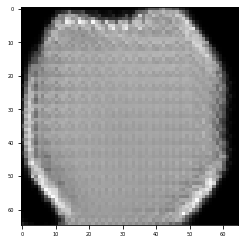

[Epoch 302/20000] [G_A loss: 0.215708] [D_B loss: 0.254380]

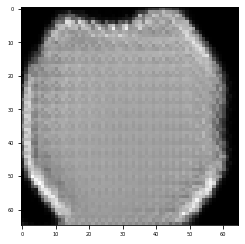

[Epoch 303/20000] [G_A loss: 0.296574] [D_B loss: 0.252539]

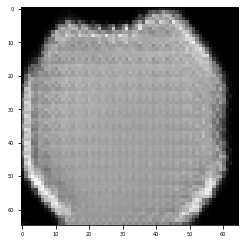

[Epoch 304/20000] [G_A loss: 0.214162] [D_B loss: 0.251897]

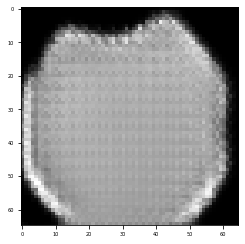

[Epoch 305/20000] [G_A loss: 0.293897] [D_B loss: 0.251131]

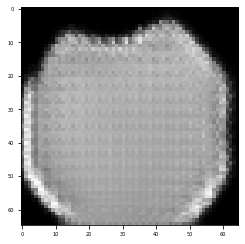

[Epoch 306/20000] [G_A loss: 0.214069] [D_B loss: 0.250406]

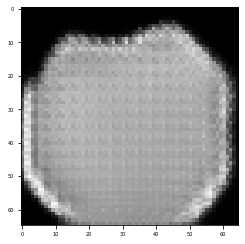

[Epoch 307/20000] [G_A loss: 0.293051] [D_B loss: 0.249926]

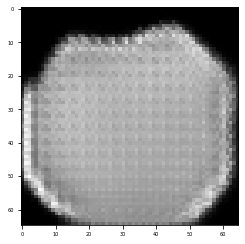

[Epoch 308/20000] [G_A loss: 0.212985] [D_B loss: 0.249769]

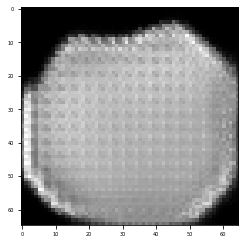

[Epoch 309/20000] [G_A loss: 0.294358] [D_B loss: 0.249786]

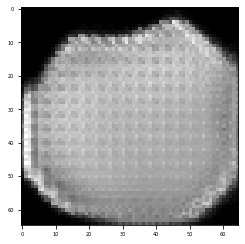

[Epoch 310/20000] [G_A loss: 0.210796] [D_B loss: 0.250019]

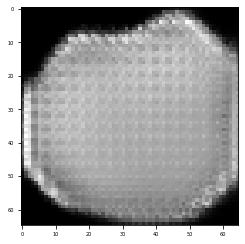

[Epoch 311/20000] [G_A loss: 0.297235] [D_B loss: 0.250259]

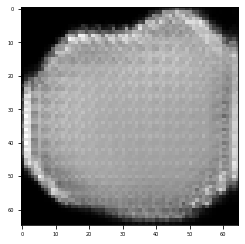

[Epoch 312/20000] [G_A loss: 0.207405] [D_B loss: 0.250536]

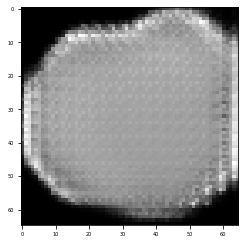

[Epoch 313/20000] [G_A loss: 0.302030] [D_B loss: 0.250788]

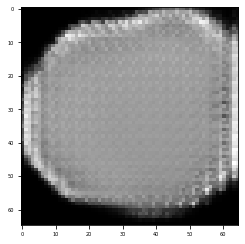

[Epoch 314/20000] [G_A loss: 0.202731] [D_B loss: 0.251026]

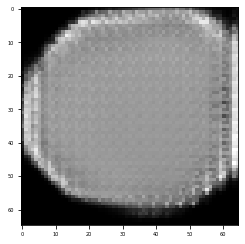

[Epoch 315/20000] [G_A loss: 0.309691] [D_B loss: 0.251225]

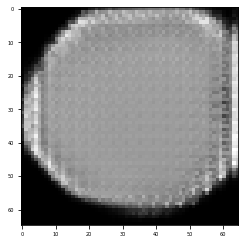

[Epoch 316/20000] [G_A loss: 0.196089] [D_B loss: 0.251681]

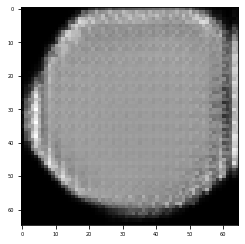

[Epoch 317/20000] [G_A loss: 0.319724] [D_B loss: 0.252458]

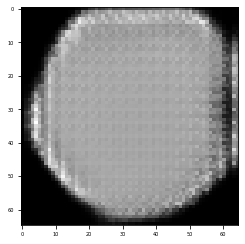

[Epoch 318/20000] [G_A loss: 0.186882] [D_B loss: 0.253701]

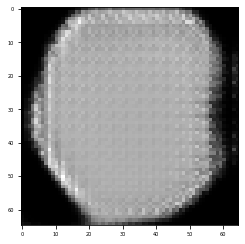

[Epoch 319/20000] [G_A loss: 0.333232] [D_B loss: 0.254726]

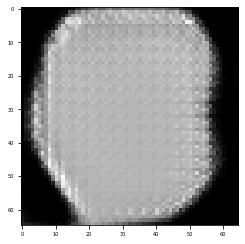

[Epoch 320/20000] [G_A loss: 0.175832] [D_B loss: 0.255921]

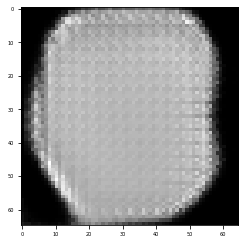

[Epoch 321/20000] [G_A loss: 0.350776] [D_B loss: 0.257306]

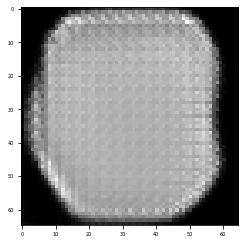

[Epoch 322/20000] [G_A loss: 0.164008] [D_B loss: 0.258954]

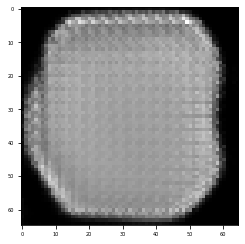

[Epoch 323/20000] [G_A loss: 0.369373] [D_B loss: 0.260757]

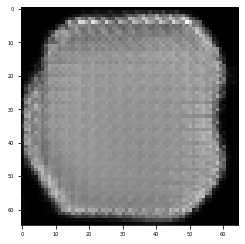

[Epoch 324/20000] [G_A loss: 0.152683] [D_B loss: 0.262816]

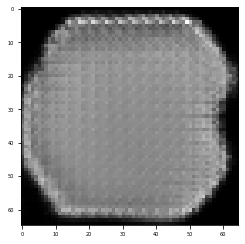

[Epoch 325/20000] [G_A loss: 0.387207] [D_B loss: 0.264821]

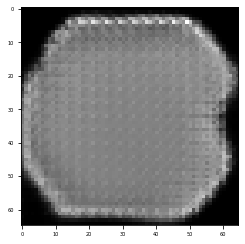

[Epoch 326/20000] [G_A loss: 0.144055] [D_B loss: 0.266682]

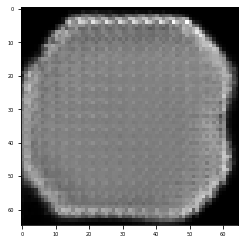

[Epoch 327/20000] [G_A loss: 0.400470] [D_B loss: 0.268125]

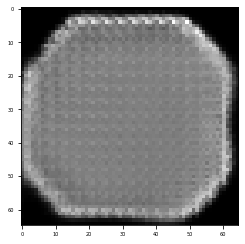

[Epoch 328/20000] [G_A loss: 0.140081] [D_B loss: 0.268954]

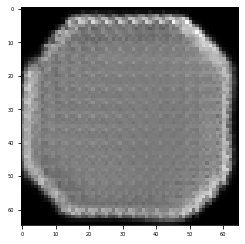

[Epoch 329/20000] [G_A loss: 0.404856] [D_B loss: 0.269114]

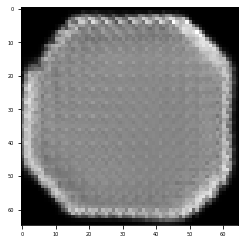

[Epoch 330/20000] [G_A loss: 0.141251] [D_B loss: 0.268801]

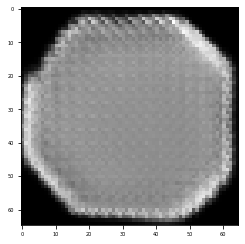

[Epoch 331/20000] [G_A loss: 0.398432] [D_B loss: 0.267926]

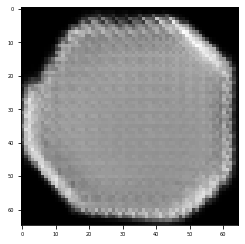

[Epoch 332/20000] [G_A loss: 0.147478] [D_B loss: 0.266669]

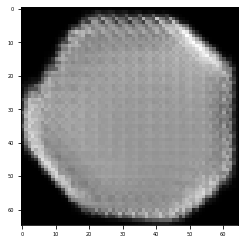

[Epoch 333/20000] [G_A loss: 0.382824] [D_B loss: 0.264897]

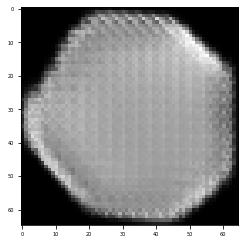

[Epoch 334/20000] [G_A loss: 0.158365] [D_B loss: 0.262755]

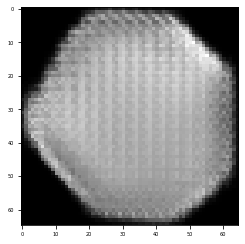

[Epoch 335/20000] [G_A loss: 0.361910] [D_B loss: 0.260212]

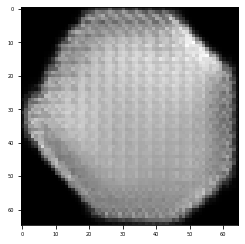

[Epoch 336/20000] [G_A loss: 0.172809] [D_B loss: 0.257991]

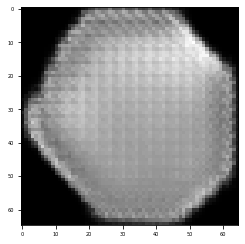

[Epoch 337/20000] [G_A loss: 0.340349] [D_B loss: 0.256377]

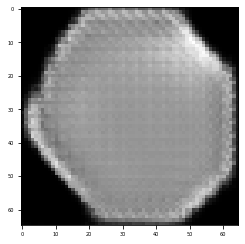

[Epoch 338/20000] [G_A loss: 0.186634] [D_B loss: 0.255322]

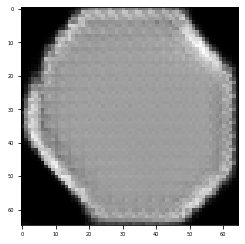

[Epoch 339/20000] [G_A loss: 0.321883] [D_B loss: 0.254427]

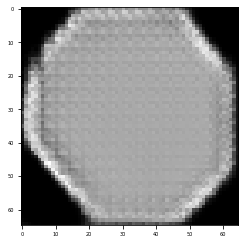

[Epoch 340/20000] [G_A loss: 0.197385] [D_B loss: 0.253713]

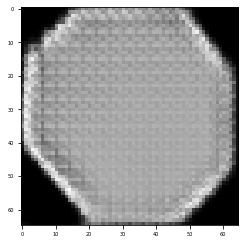

[Epoch 341/20000] [G_A loss: 0.308705] [D_B loss: 0.252977]

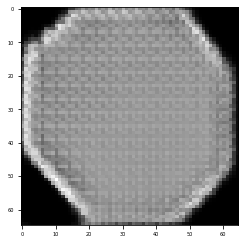

[Epoch 342/20000] [G_A loss: 0.206270] [D_B loss: 0.252285]

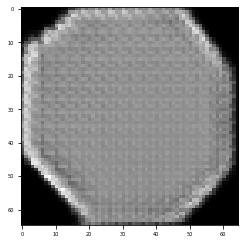

[Epoch 343/20000] [G_A loss: 0.299417] [D_B loss: 0.251687]

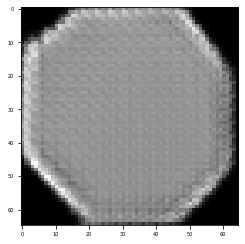

[Epoch 344/20000] [G_A loss: 0.213054] [D_B loss: 0.251192]

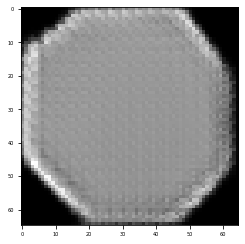

[Epoch 345/20000] [G_A loss: 0.293156] [D_B loss: 0.250876]

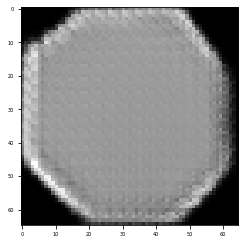

[Epoch 346/20000] [G_A loss: 0.217530] [D_B loss: 0.250690]

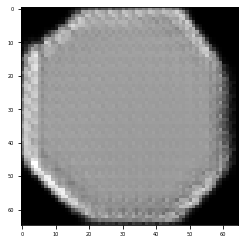

[Epoch 347/20000] [G_A loss: 0.289409] [D_B loss: 0.250644]

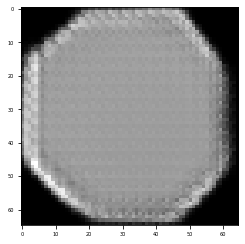

[Epoch 348/20000] [G_A loss: 0.220502] [D_B loss: 0.250805]

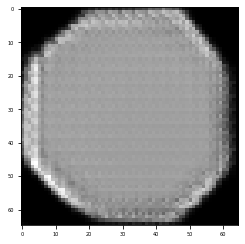

[Epoch 349/20000] [G_A loss: 0.287421] [D_B loss: 0.251182]

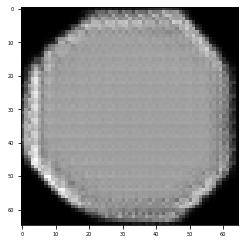

[Epoch 350/20000] [G_A loss: 0.222299] [D_B loss: 0.251875]

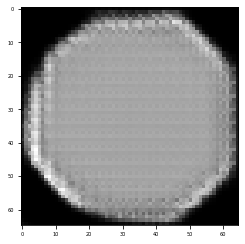

[Epoch 351/20000] [G_A loss: 0.286822] [D_B loss: 0.252738]

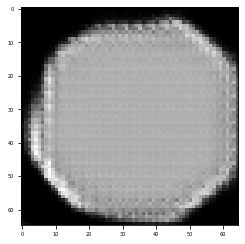

[Epoch 352/20000] [G_A loss: 0.224798] [D_B loss: 0.253483]

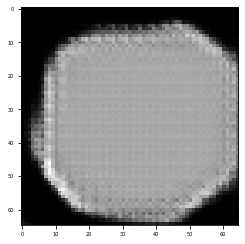

[Epoch 353/20000] [G_A loss: 0.288241] [D_B loss: 0.254364]

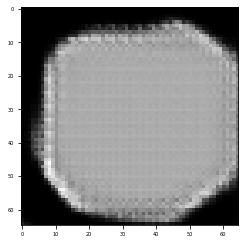

[Epoch 354/20000] [G_A loss: 0.228251] [D_B loss: 0.255477]

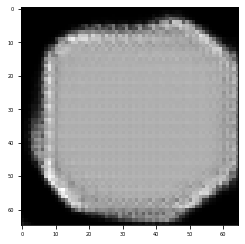

[Epoch 355/20000] [G_A loss: 0.290242] [D_B loss: 0.256688]

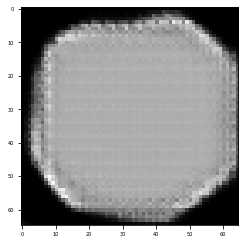

[Epoch 356/20000] [G_A loss: 0.231952] [D_B loss: 0.257546]

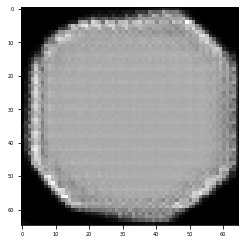

[Epoch 357/20000] [G_A loss: 0.288745] [D_B loss: 0.257508]

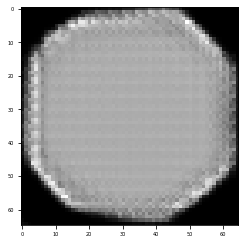

[Epoch 358/20000] [G_A loss: 0.233176] [D_B loss: 0.256306]

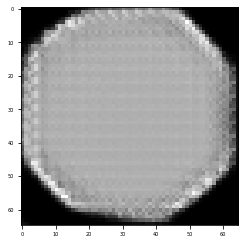

[Epoch 359/20000] [G_A loss: 0.281605] [D_B loss: 0.254107]

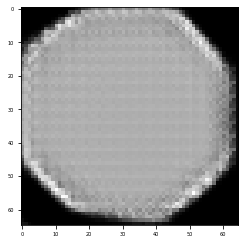

[Epoch 360/20000] [G_A loss: 0.232364] [D_B loss: 0.251840]

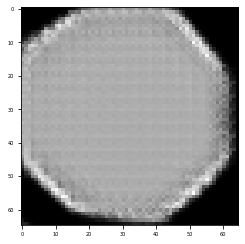

[Epoch 361/20000] [G_A loss: 0.274758] [D_B loss: 0.250178]

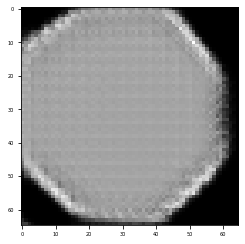

[Epoch 362/20000] [G_A loss: 0.231477] [D_B loss: 0.249241]

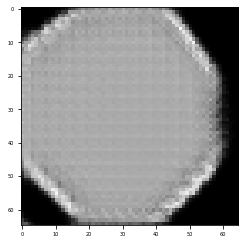

[Epoch 363/20000] [G_A loss: 0.274599] [D_B loss: 0.248748]

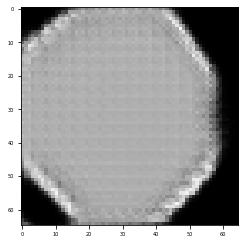

[Epoch 364/20000] [G_A loss: 0.229044] [D_B loss: 0.248501]

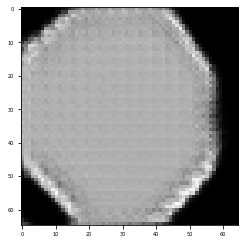

[Epoch 365/20000] [G_A loss: 0.279937] [D_B loss: 0.248464]

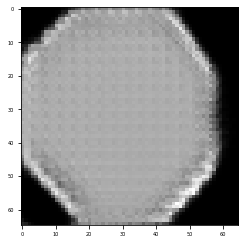

[Epoch 366/20000] [G_A loss: 0.222878] [D_B loss: 0.248799]

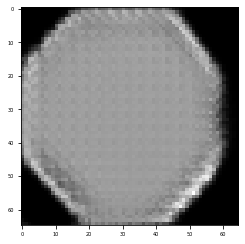

[Epoch 367/20000] [G_A loss: 0.288703] [D_B loss: 0.249760]

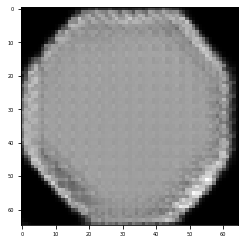

[Epoch 368/20000] [G_A loss: 0.212675] [D_B loss: 0.251134]

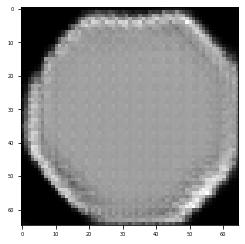

[Epoch 369/20000] [G_A loss: 0.303393] [D_B loss: 0.252556]

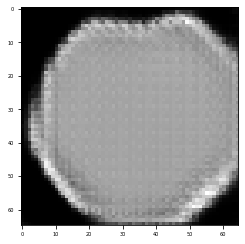

[Epoch 370/20000] [G_A loss: 0.199291] [D_B loss: 0.254387]

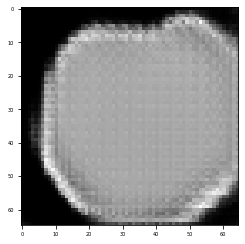

[Epoch 371/20000] [G_A loss: 0.328081] [D_B loss: 0.257011]

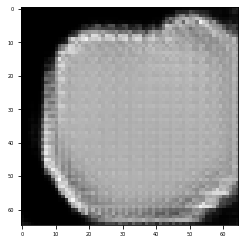

[Epoch 372/20000] [G_A loss: 0.182731] [D_B loss: 0.261068]

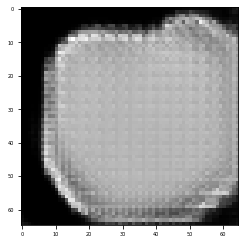

[Epoch 373/20000] [G_A loss: 0.369298] [D_B loss: 0.267052]

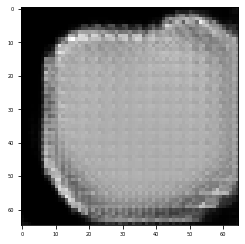

[Epoch 374/20000] [G_A loss: 0.161968] [D_B loss: 0.275228]

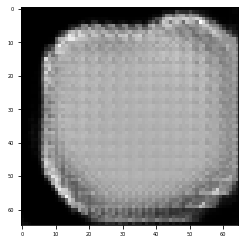

[Epoch 375/20000] [G_A loss: 0.430438] [D_B loss: 0.284749]

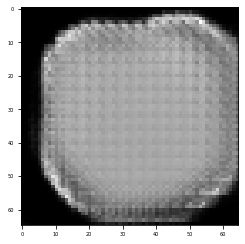

[Epoch 376/20000] [G_A loss: 0.133603] [D_B loss: 0.294738]

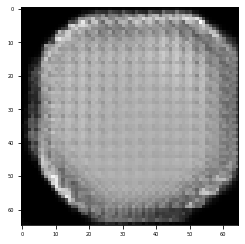

[Epoch 377/20000] [G_A loss: 0.499834] [D_B loss: 0.304711]

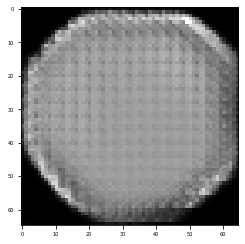

[Epoch 378/20000] [G_A loss: 0.101679] [D_B loss: 0.314645]

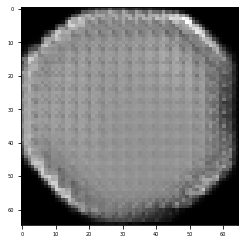

[Epoch 379/20000] [G_A loss: 0.561999] [D_B loss: 0.323420]

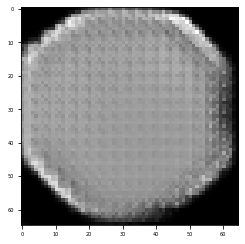

[Epoch 380/20000] [G_A loss: 0.084259] [D_B loss: 0.327449]

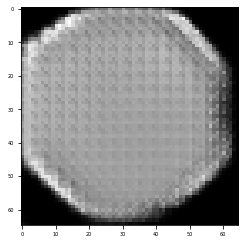

[Epoch 381/20000] [G_A loss: 0.569833] [D_B loss: 0.323868]

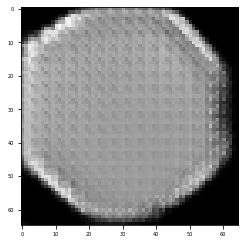

[Epoch 382/20000] [G_A loss: 0.090553] [D_B loss: 0.312529]

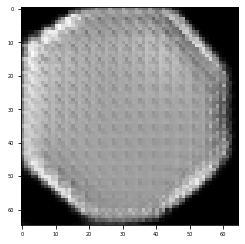

[Epoch 383/20000] [G_A loss: 0.493409] [D_B loss: 0.296287]

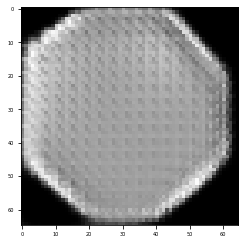

[Epoch 384/20000] [G_A loss: 0.129197] [D_B loss: 0.279687]

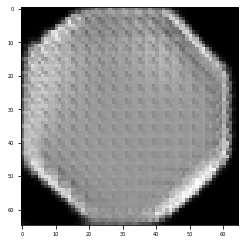

[Epoch 385/20000] [G_A loss: 0.381391] [D_B loss: 0.266174]

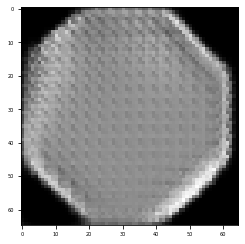

[Epoch 386/20000] [G_A loss: 0.186756] [D_B loss: 0.257156]

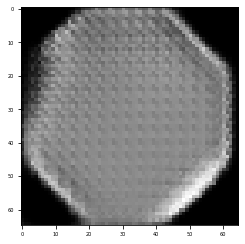

[Epoch 387/20000] [G_A loss: 0.297660] [D_B loss: 0.252104]

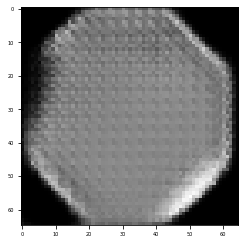

[Epoch 388/20000] [G_A loss: 0.232449] [D_B loss: 0.249718]

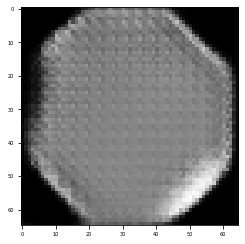

[Epoch 389/20000] [G_A loss: 0.257625] [D_B loss: 0.248710]

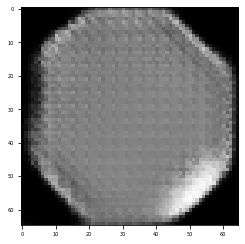

[Epoch 390/20000] [G_A loss: 0.253575] [D_B loss: 0.248356]

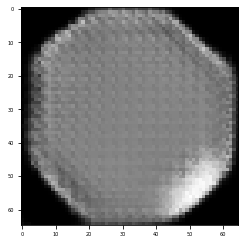

[Epoch 391/20000] [G_A loss: 0.245158] [D_B loss: 0.248243]

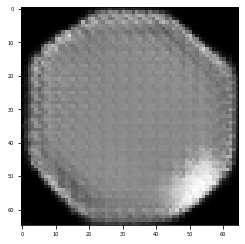

[Epoch 392/20000] [G_A loss: 0.258300] [D_B loss: 0.248201]

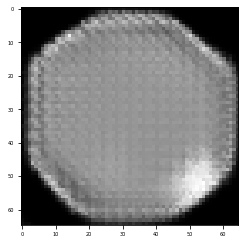

[Epoch 393/20000] [G_A loss: 0.244423] [D_B loss: 0.248151]

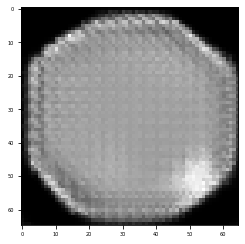

[Epoch 394/20000] [G_A loss: 0.256943] [D_B loss: 0.248077]

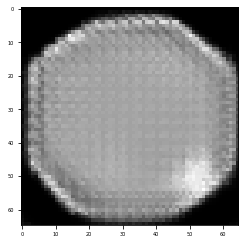

[Epoch 395/20000] [G_A loss: 0.246625] [D_B loss: 0.248007]

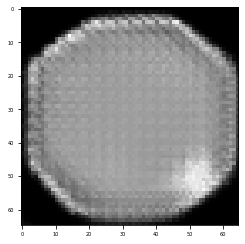

[Epoch 396/20000] [G_A loss: 0.254861] [D_B loss: 0.247945]

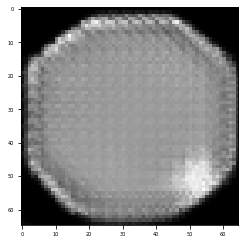

[Epoch 397/20000] [G_A loss: 0.248509] [D_B loss: 0.247912]

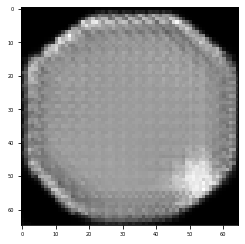

[Epoch 398/20000] [G_A loss: 0.253482] [D_B loss: 0.247901]

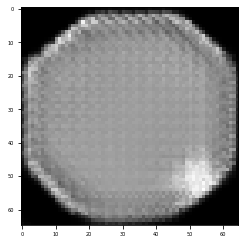

[Epoch 399/20000] [G_A loss: 0.249453] [D_B loss: 0.247918]

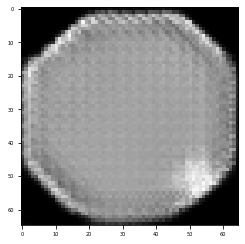

[Epoch 400/20000] [G_A loss: 0.252791] [D_B loss: 0.247937]

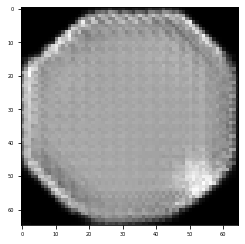

[Epoch 401/20000] [G_A loss: 0.249898] [D_B loss: 0.247964]

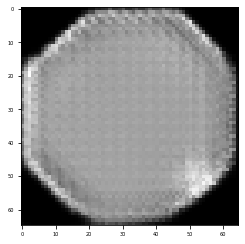

[Epoch 402/20000] [G_A loss: 0.252446] [D_B loss: 0.247985]

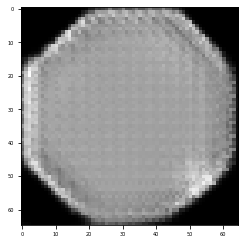

[Epoch 403/20000] [G_A loss: 0.250130] [D_B loss: 0.247983]

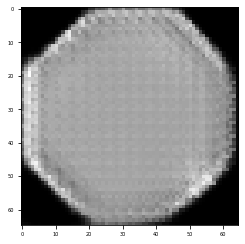

[Epoch 404/20000] [G_A loss: 0.252395] [D_B loss: 0.247961]

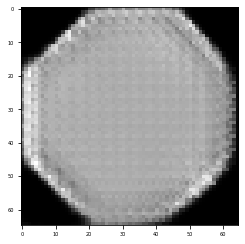

[Epoch 405/20000] [G_A loss: 0.250233] [D_B loss: 0.247932]

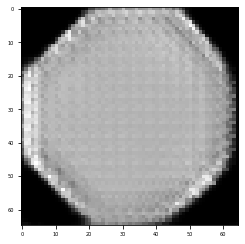

[Epoch 406/20000] [G_A loss: 0.252365] [D_B loss: 0.247917]

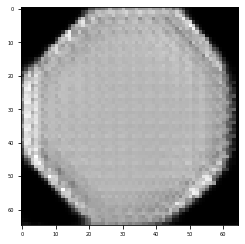

[Epoch 407/20000] [G_A loss: 0.250345] [D_B loss: 0.247899]

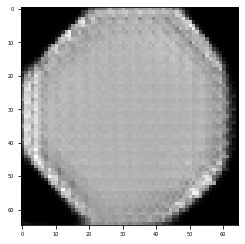

[Epoch 408/20000] [G_A loss: 0.252429] [D_B loss: 0.247862]

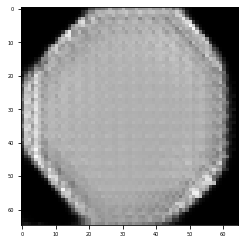

[Epoch 409/20000] [G_A loss: 0.250369] [D_B loss: 0.247802]

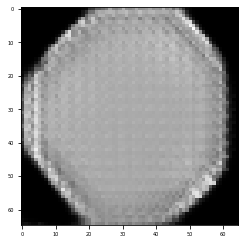

[Epoch 410/20000] [G_A loss: 0.252660] [D_B loss: 0.247750]

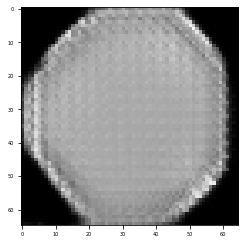

[Epoch 411/20000] [G_A loss: 0.250363] [D_B loss: 0.247723]

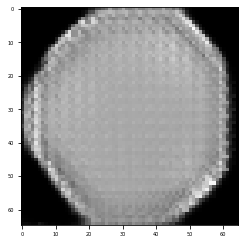

[Epoch 412/20000] [G_A loss: 0.252819] [D_B loss: 0.247726]

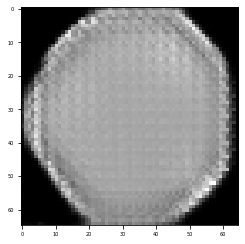

[Epoch 413/20000] [G_A loss: 0.250008] [D_B loss: 0.247807]

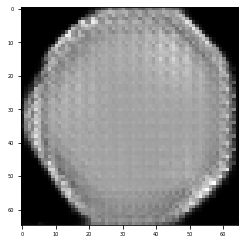

[Epoch 414/20000] [G_A loss: 0.252920] [D_B loss: 0.247935]

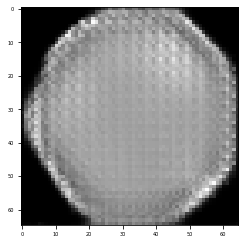

[Epoch 415/20000] [G_A loss: 0.249435] [D_B loss: 0.248037]

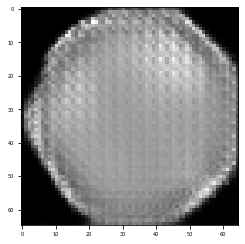

[Epoch 416/20000] [G_A loss: 0.253033] [D_B loss: 0.248147]

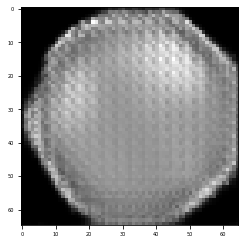

[Epoch 417/20000] [G_A loss: 0.248920] [D_B loss: 0.248214]

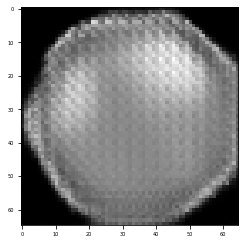

[Epoch 418/20000] [G_A loss: 0.253856] [D_B loss: 0.248133]

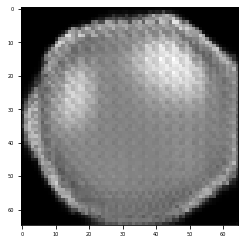

[Epoch 419/20000] [G_A loss: 0.248805] [D_B loss: 0.248117]

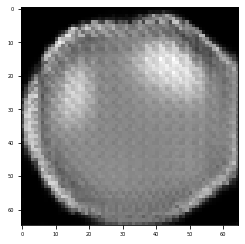

[Epoch 420/20000] [G_A loss: 0.254665] [D_B loss: 0.248257]

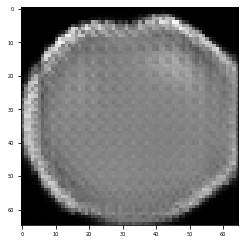

[Epoch 421/20000] [G_A loss: 0.248769] [D_B loss: 0.248377]

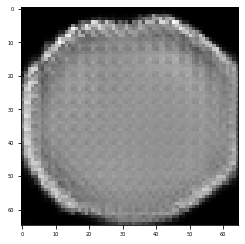

[Epoch 422/20000] [G_A loss: 0.255573] [D_B loss: 0.248490]

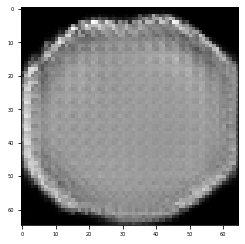

[Epoch 423/20000] [G_A loss: 0.248085] [D_B loss: 0.248702]

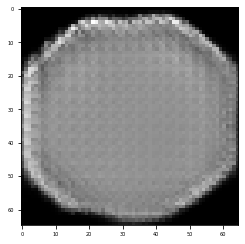

[Epoch 424/20000] [G_A loss: 0.257775] [D_B loss: 0.249043]

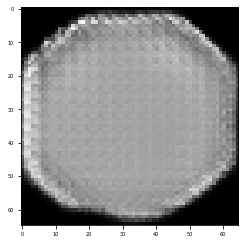

[Epoch 425/20000] [G_A loss: 0.246884] [D_B loss: 0.249503]

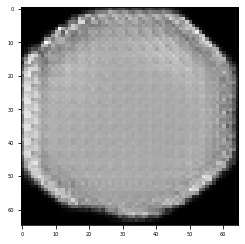

[Epoch 426/20000] [G_A loss: 0.261188] [D_B loss: 0.250070]

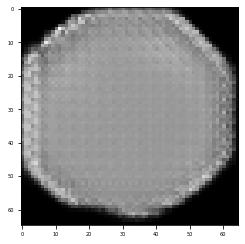

[Epoch 427/20000] [G_A loss: 0.245114] [D_B loss: 0.250716]

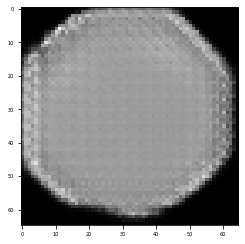

[Epoch 428/20000] [G_A loss: 0.266327] [D_B loss: 0.251482]

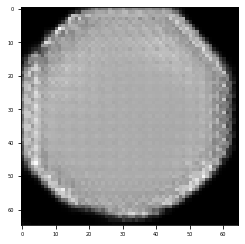

[Epoch 429/20000] [G_A loss: 0.242229] [D_B loss: 0.252324]

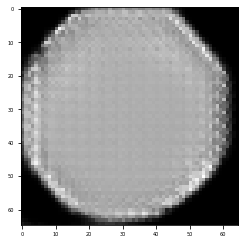

[Epoch 430/20000] [G_A loss: 0.273031] [D_B loss: 0.253068]

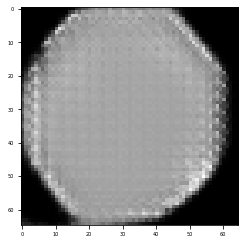

[Epoch 431/20000] [G_A loss: 0.237547] [D_B loss: 0.253511]

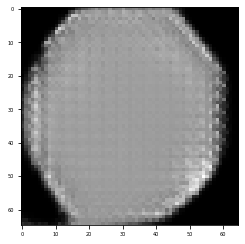

[Epoch 432/20000] [G_A loss: 0.280212] [D_B loss: 0.253697]

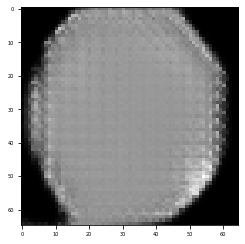

[Epoch 433/20000] [G_A loss: 0.230141] [D_B loss: 0.253458]

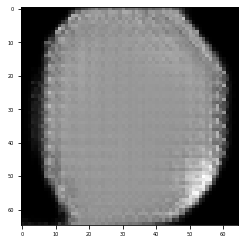

[Epoch 434/20000] [G_A loss: 0.288193] [D_B loss: 0.252948]

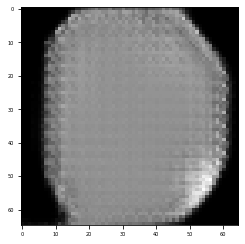

[Epoch 435/20000] [G_A loss: 0.220072] [D_B loss: 0.252511]

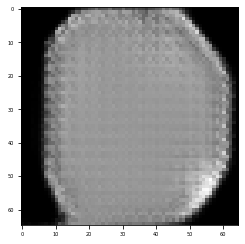

[Epoch 436/20000] [G_A loss: 0.299227] [D_B loss: 0.252386]

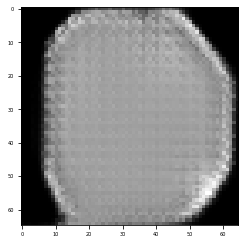

[Epoch 437/20000] [G_A loss: 0.207650] [D_B loss: 0.252920]

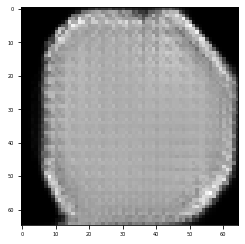

[Epoch 438/20000] [G_A loss: 0.316906] [D_B loss: 0.254318]

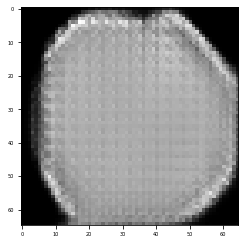

[Epoch 439/20000] [G_A loss: 0.191813] [D_B loss: 0.257005]

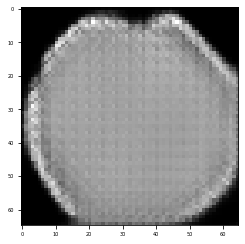

[Epoch 440/20000] [G_A loss: 0.345143] [D_B loss: 0.260320]

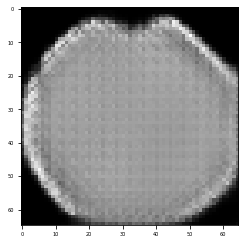

[Epoch 441/20000] [G_A loss: 0.171637] [D_B loss: 0.264469]

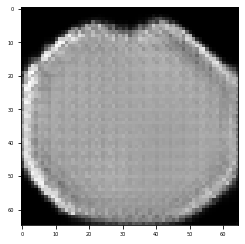

[Epoch 442/20000] [G_A loss: 0.385770] [D_B loss: 0.269350]

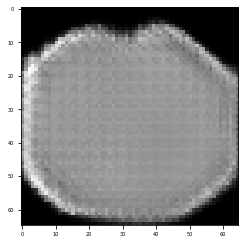

[Epoch 443/20000] [G_A loss: 0.146380] [D_B loss: 0.274904]

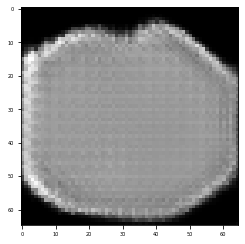

[Epoch 444/20000] [G_A loss: 0.438250] [D_B loss: 0.281348]

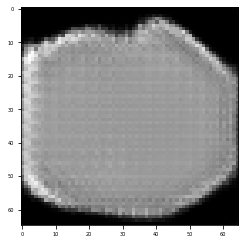

[Epoch 445/20000] [G_A loss: 0.118531] [D_B loss: 0.289570]

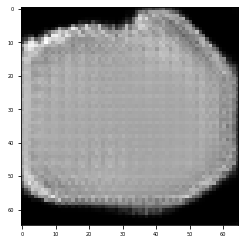

[Epoch 446/20000] [G_A loss: 0.499754] [D_B loss: 0.299446]

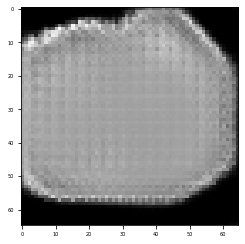

[Epoch 447/20000] [G_A loss: 0.098113] [D_B loss: 0.310469]

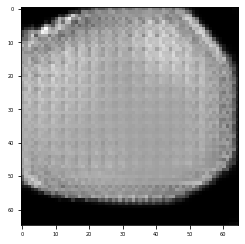

[Epoch 448/20000] [G_A loss: 0.553887] [D_B loss: 0.319709]

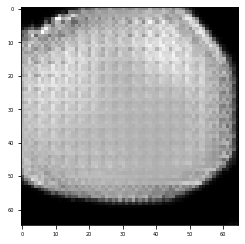

[Epoch 449/20000] [G_A loss: 0.092066] [D_B loss: 0.324615]

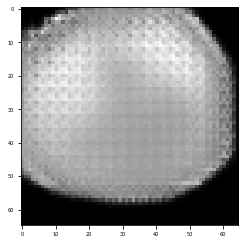

[Epoch 450/20000] [G_A loss: 0.558404] [D_B loss: 0.321625]

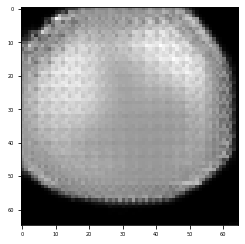

[Epoch 451/20000] [G_A loss: 0.101085] [D_B loss: 0.311171]

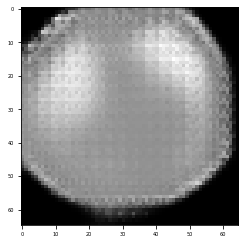

[Epoch 452/20000] [G_A loss: 0.487946] [D_B loss: 0.295402]

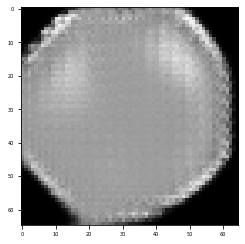

[Epoch 453/20000] [G_A loss: 0.129536] [D_B loss: 0.279177]

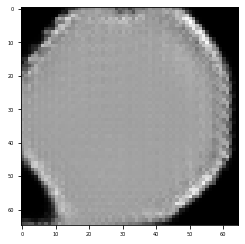

[Epoch 454/20000] [G_A loss: 0.388217] [D_B loss: 0.266181]

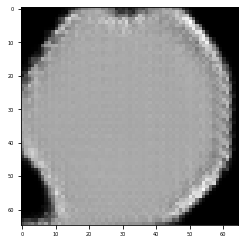

[Epoch 455/20000] [G_A loss: 0.174986] [D_B loss: 0.257646]

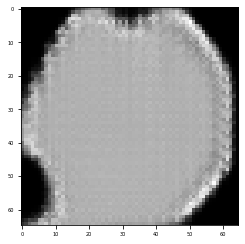

[Epoch 456/20000] [G_A loss: 0.314895] [D_B loss: 0.252764]

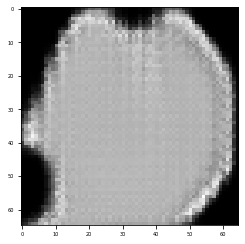

[Epoch 457/20000] [G_A loss: 0.214904] [D_B loss: 0.250155]

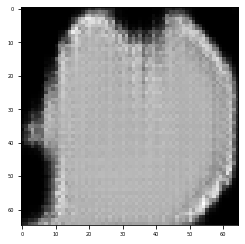

[Epoch 458/20000] [G_A loss: 0.275988] [D_B loss: 0.248744]

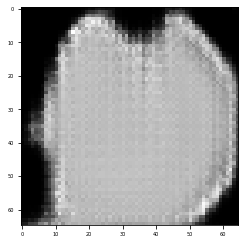

[Epoch 459/20000] [G_A loss: 0.238006] [D_B loss: 0.248141]

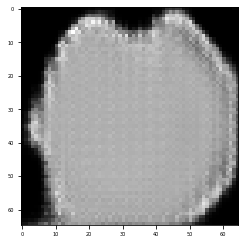

[Epoch 460/20000] [G_A loss: 0.259396] [D_B loss: 0.247910]

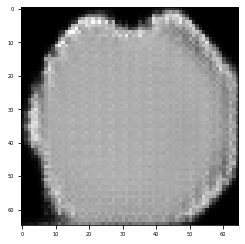

[Epoch 461/20000] [G_A loss: 0.247448] [D_B loss: 0.247927]

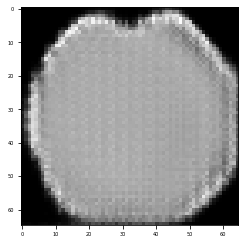

[Epoch 462/20000] [G_A loss: 0.253081] [D_B loss: 0.248048]

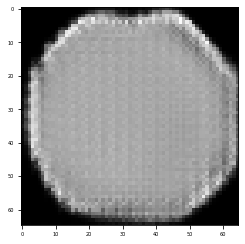

[Epoch 463/20000] [G_A loss: 0.250719] [D_B loss: 0.248095]

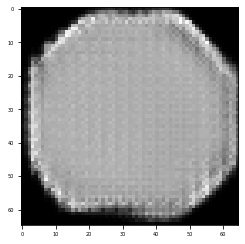

[Epoch 464/20000] [G_A loss: 0.251314] [D_B loss: 0.248056]

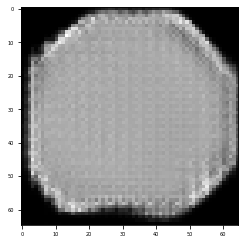

[Epoch 465/20000] [G_A loss: 0.251579] [D_B loss: 0.247995]

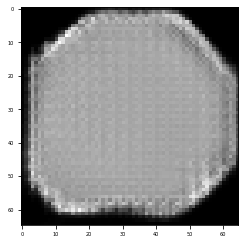

[Epoch 466/20000] [G_A loss: 0.251263] [D_B loss: 0.247927]

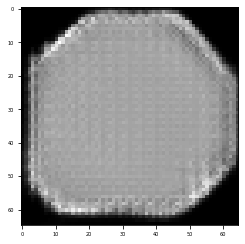

[Epoch 467/20000] [G_A loss: 0.251552] [D_B loss: 0.247862]

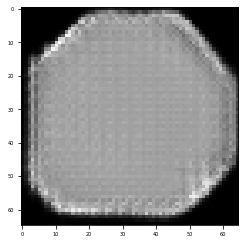

[Epoch 468/20000] [G_A loss: 0.251584] [D_B loss: 0.247813]

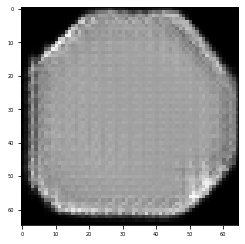

[Epoch 469/20000] [G_A loss: 0.251442] [D_B loss: 0.247803]

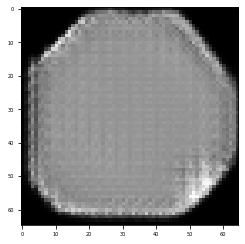

[Epoch 470/20000] [G_A loss: 0.251728] [D_B loss: 0.247830]

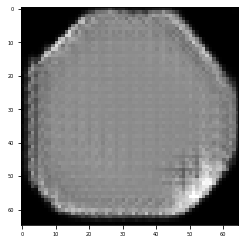

[Epoch 471/20000] [G_A loss: 0.251107] [D_B loss: 0.247888]

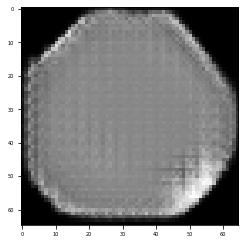

[Epoch 472/20000] [G_A loss: 0.252018] [D_B loss: 0.247946]

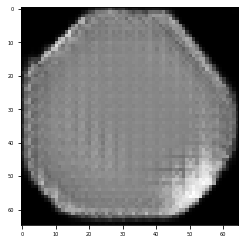

[Epoch 473/20000] [G_A loss: 0.250783] [D_B loss: 0.247996]

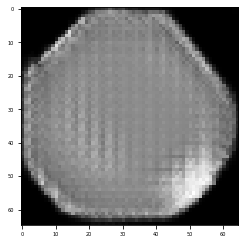

[Epoch 474/20000] [G_A loss: 0.252243] [D_B loss: 0.248040]

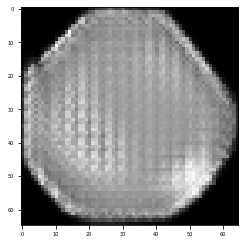

[Epoch 475/20000] [G_A loss: 0.250654] [D_B loss: 0.248037]

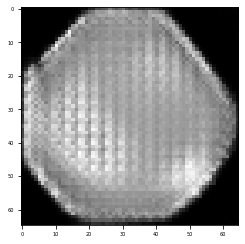

[Epoch 476/20000] [G_A loss: 0.252420] [D_B loss: 0.248042]

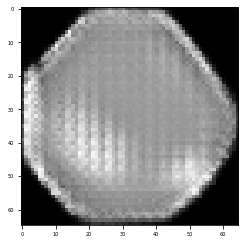

[Epoch 477/20000] [G_A loss: 0.251073] [D_B loss: 0.248111]

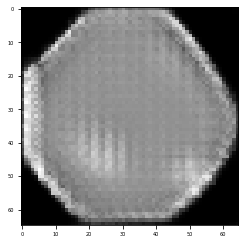

[Epoch 478/20000] [G_A loss: 0.252938] [D_B loss: 0.248234]

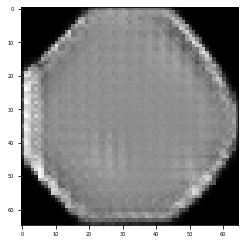

[Epoch 479/20000] [G_A loss: 0.250792] [D_B loss: 0.248325]

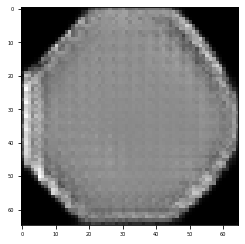

[Epoch 480/20000] [G_A loss: 0.253475] [D_B loss: 0.248431]

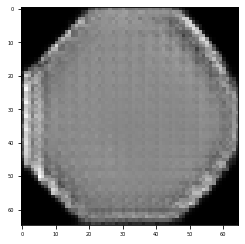

[Epoch 481/20000] [G_A loss: 0.250878] [D_B loss: 0.248531]

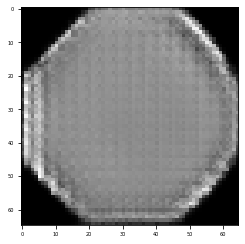

[Epoch 482/20000] [G_A loss: 0.254145] [D_B loss: 0.248655]

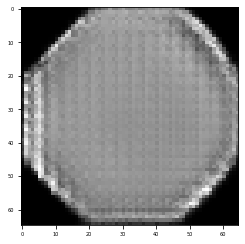

[Epoch 483/20000] [G_A loss: 0.251021] [D_B loss: 0.248824]

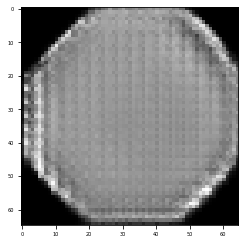

[Epoch 484/20000] [G_A loss: 0.255207] [D_B loss: 0.249090]

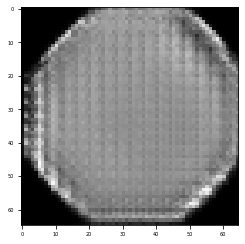

[Epoch 485/20000] [G_A loss: 0.250942] [D_B loss: 0.249541]

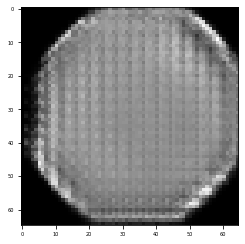

[Epoch 486/20000] [G_A loss: 0.256878] [D_B loss: 0.250080]

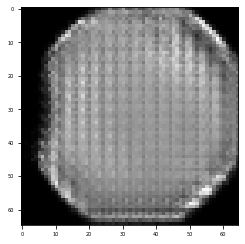

[Epoch 487/20000] [G_A loss: 0.250598] [D_B loss: 0.250681]

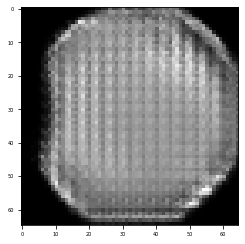

[Epoch 488/20000] [G_A loss: 0.259457] [D_B loss: 0.251447]

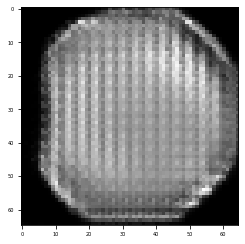

[Epoch 489/20000] [G_A loss: 0.250219] [D_B loss: 0.252192]

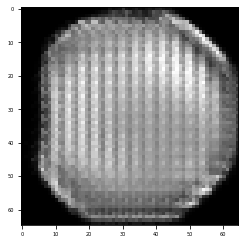

[Epoch 490/20000] [G_A loss: 0.264072] [D_B loss: 0.252909]

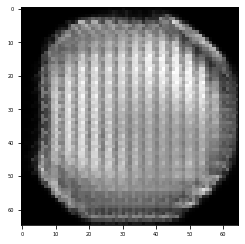

[Epoch 491/20000] [G_A loss: 0.249938] [D_B loss: 0.253896]

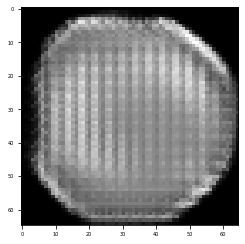

[Epoch 492/20000] [G_A loss: 0.271357] [D_B loss: 0.255825]

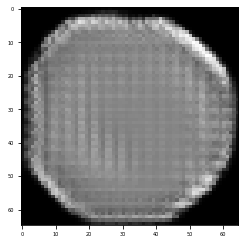

[Epoch 493/20000] [G_A loss: 0.247274] [D_B loss: 0.257954]

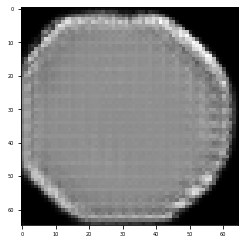

[Epoch 494/20000] [G_A loss: 0.281648] [D_B loss: 0.260587]

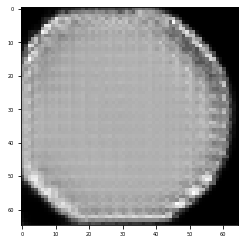

[Epoch 495/20000] [G_A loss: 0.244921] [D_B loss: 0.263403]

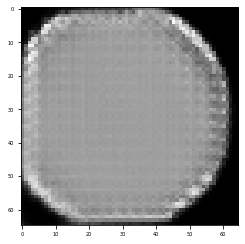

[Epoch 496/20000] [G_A loss: 0.296063] [D_B loss: 0.266628]

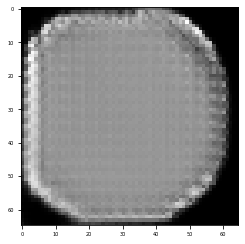

[Epoch 497/20000] [G_A loss: 0.243347] [D_B loss: 0.269389]

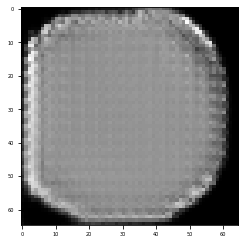

[Epoch 498/20000] [G_A loss: 0.308523] [D_B loss: 0.271946]

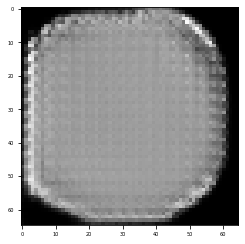

[Epoch 499/20000] [G_A loss: 0.244833] [D_B loss: 0.273444]

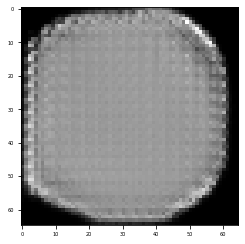

[Epoch 500/20000] [G_A loss: 0.308537] [D_B loss: 0.273910]

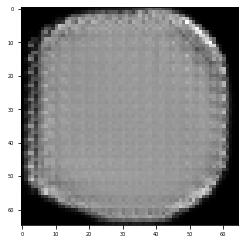

[Epoch 501/20000] [G_A loss: 0.252609] [D_B loss: 0.272619]

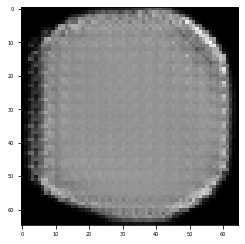

[Epoch 502/20000] [G_A loss: 0.288941] [D_B loss: 0.269897]

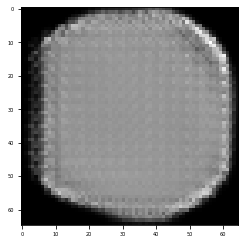

[Epoch 503/20000] [G_A loss: 0.267048] [D_B loss: 0.266340]

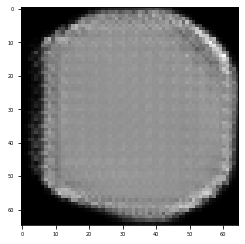

[Epoch 504/20000] [G_A loss: 0.258002] [D_B loss: 0.262808]

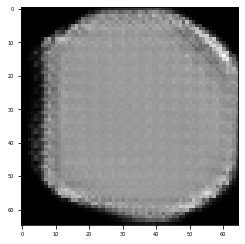

[Epoch 505/20000] [G_A loss: 0.284855] [D_B loss: 0.259683]

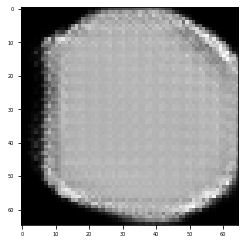

[Epoch 506/20000] [G_A loss: 0.230392] [D_B loss: 0.257285]

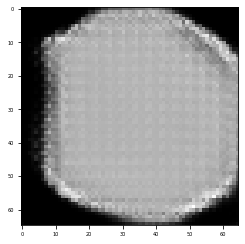

[Epoch 507/20000] [G_A loss: 0.300395] [D_B loss: 0.255626]

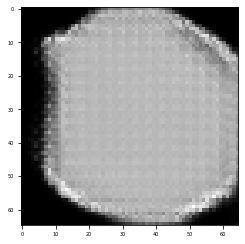

[Epoch 508/20000] [G_A loss: 0.213168] [D_B loss: 0.254575]

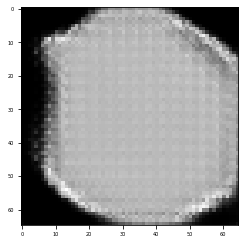

[Epoch 509/20000] [G_A loss: 0.310112] [D_B loss: 0.254061]

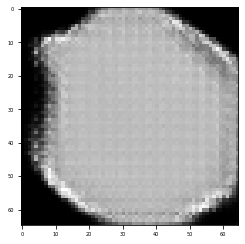

[Epoch 510/20000] [G_A loss: 0.204311] [D_B loss: 0.254246]

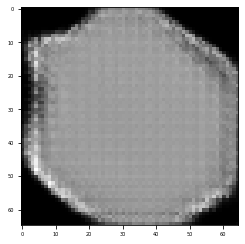

[Epoch 511/20000] [G_A loss: 0.314367] [D_B loss: 0.254622]

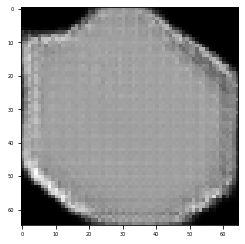

[Epoch 512/20000] [G_A loss: 0.201481] [D_B loss: 0.254751]

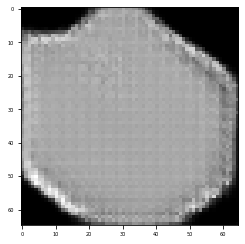

[Epoch 513/20000] [G_A loss: 0.315830] [D_B loss: 0.254896]

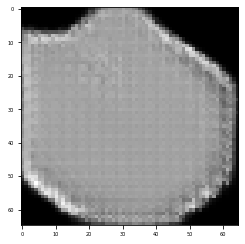

[Epoch 514/20000] [G_A loss: 0.201494] [D_B loss: 0.254928]

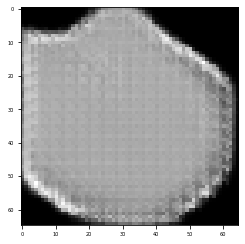

[Epoch 515/20000] [G_A loss: 0.315482] [D_B loss: 0.254772]

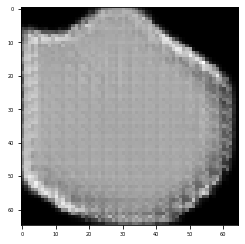

[Epoch 516/20000] [G_A loss: 0.202003] [D_B loss: 0.254417]

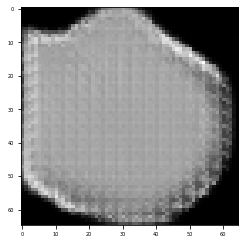

[Epoch 517/20000] [G_A loss: 0.314187] [D_B loss: 0.253959]

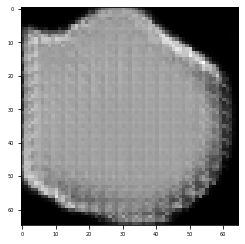

[Epoch 518/20000] [G_A loss: 0.201975] [D_B loss: 0.253422]

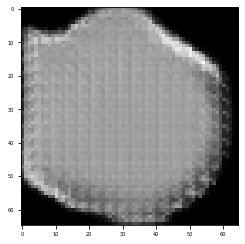

[Epoch 519/20000] [G_A loss: 0.313592] [D_B loss: 0.252924]

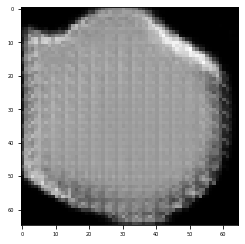

[Epoch 520/20000] [G_A loss: 0.200124] [D_B loss: 0.252685]

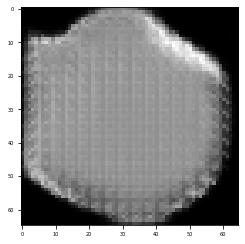

[Epoch 521/20000] [G_A loss: 0.314857] [D_B loss: 0.252704]

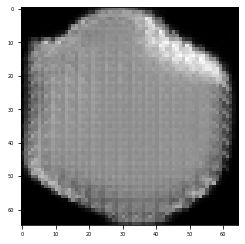

[Epoch 522/20000] [G_A loss: 0.195808] [D_B loss: 0.253238]

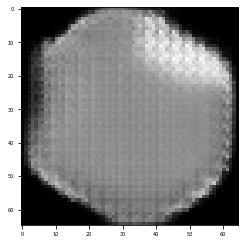

[Epoch 523/20000] [G_A loss: 0.320253] [D_B loss: 0.253521]

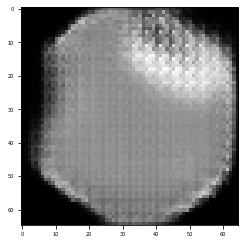

[Epoch 524/20000] [G_A loss: 0.189556] [D_B loss: 0.253505]

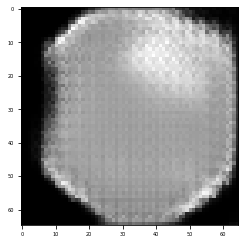

[Epoch 525/20000] [G_A loss: 0.331564] [D_B loss: 0.253934]

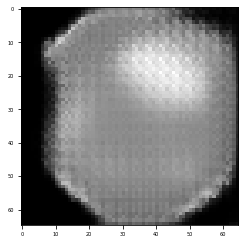

[Epoch 526/20000] [G_A loss: 0.179996] [D_B loss: 0.255316]

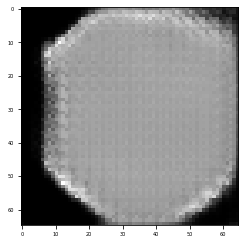

[Epoch 527/20000] [G_A loss: 0.350263] [D_B loss: 0.256924]

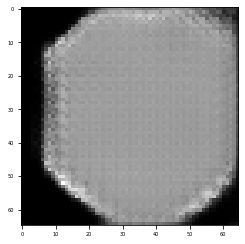

[Epoch 528/20000] [G_A loss: 0.166618] [D_B loss: 0.259008]

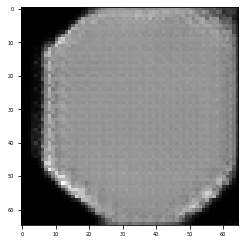

[Epoch 529/20000] [G_A loss: 0.375053] [D_B loss: 0.261772]

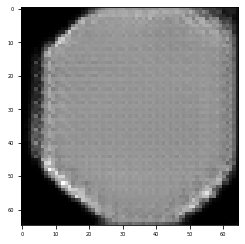

[Epoch 530/20000] [G_A loss: 0.150289] [D_B loss: 0.265896]

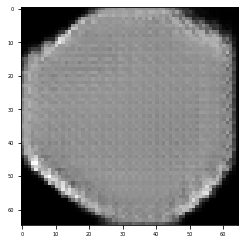

[Epoch 531/20000] [G_A loss: 0.406466] [D_B loss: 0.270237]

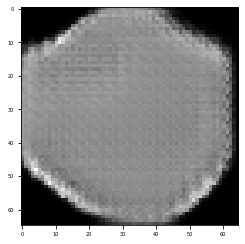

[Epoch 532/20000] [G_A loss: 0.134439] [D_B loss: 0.275281]

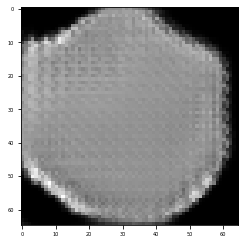

[Epoch 533/20000] [G_A loss: 0.438076] [D_B loss: 0.279972]

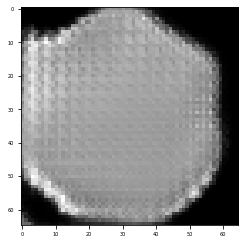

[Epoch 534/20000] [G_A loss: 0.123271] [D_B loss: 0.283526]

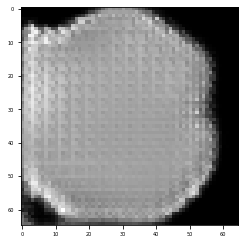

[Epoch 535/20000] [G_A loss: 0.457372] [D_B loss: 0.285094]

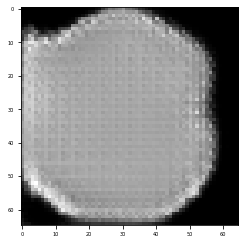

[Epoch 536/20000] [G_A loss: 0.120290] [D_B loss: 0.284633]

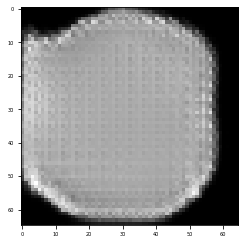

[Epoch 537/20000] [G_A loss: 0.451406] [D_B loss: 0.282477]

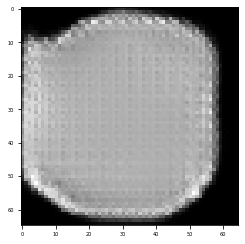

[Epoch 538/20000] [G_A loss: 0.128556] [D_B loss: 0.279129]

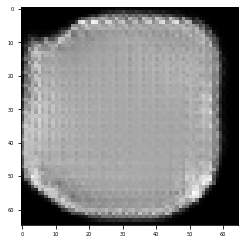

[Epoch 539/20000] [G_A loss: 0.422540] [D_B loss: 0.275183]

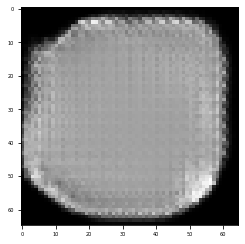

[Epoch 540/20000] [G_A loss: 0.146176] [D_B loss: 0.271227]

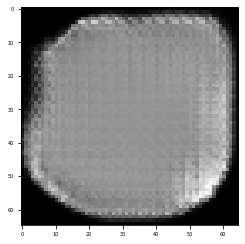

[Epoch 541/20000] [G_A loss: 0.383990] [D_B loss: 0.267072]

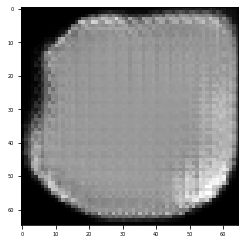

[Epoch 542/20000] [G_A loss: 0.168069] [D_B loss: 0.263339]

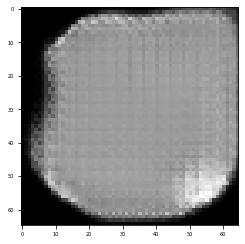

[Epoch 543/20000] [G_A loss: 0.349670] [D_B loss: 0.260095]

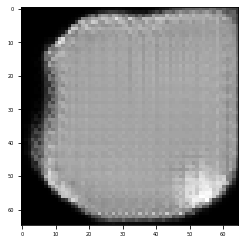

[Epoch 544/20000] [G_A loss: 0.187743] [D_B loss: 0.257439]

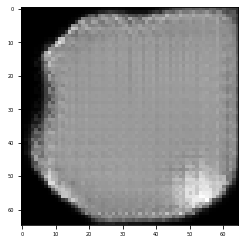

[Epoch 545/20000] [G_A loss: 0.323757] [D_B loss: 0.255190]

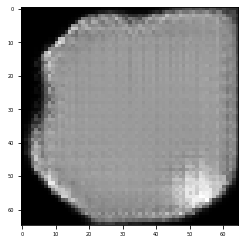

[Epoch 546/20000] [G_A loss: 0.202795] [D_B loss: 0.253324]

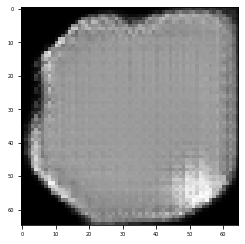

[Epoch 547/20000] [G_A loss: 0.304730] [D_B loss: 0.251906]

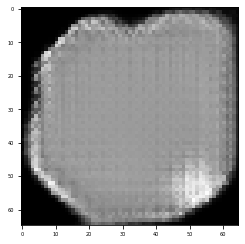

KeyboardInterrupt: ignored

In [22]:
import argparse
import os
import numpy as np
import math
import itertools
import datetime
import time
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
import sys
import random
import pickle


cuda = torch.cuda.is_available()

'''
Encoder
'''
# Encoder = EncoderNet(train=True, input_shape=(2,1,128,128))
'''
Decoder
'''
# Decoder = DecoderNet(train=True, input_shape=(1,512,128,128))

'''
Discriminator
'''
discriminator = Discriminator((1,64,64))
# discriminator_aux = Discriminator_aux((1,1,128,128))

'''
Generator
'''
G_A=GeneratorResNet(skip=False)

if cuda:
    # Encoder = Encoder.cuda()
    # Decoder = Decoder.cuda()
    discriminator = discriminator.cuda()
    # discriminator_aux=discriminator_aux.cuda()
    G_A=G_A.cuda()



opt={"lr":0.0002,"b1":0.5, "b2":0.999, "epoch":0, "n_epochs":20000, "decay_epoch":5, "lambda_cyc":10.0, "lambda_id":5.0}


optimizer_G = torch.optim.Adam(
    G_A.parameters(), lr=opt["lr"], betas=(opt["b1"], opt["b2"])
)
optimizer_D_B = torch.optim.Adam(discriminator.parameters(), lr=opt["lr"], betas=(opt["b1"], opt["b2"]))
# optimizer_D_A=torch.optim.Adam(params=discriminator_aux.parameters())


Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor
G_A.train()
discriminator.train()

'''
Training loop starts
'''
for epoch in range(opt["n_epochs"]):
    for i, batch in enumerate(zip(dataloader, dataloader2)):
       
        if (i==1): # trying to overfit on single image
          i=0
          break
        
        with torch.autograd.set_detect_anomaly(True):
          

          real_A = Variable(batch[0]["input"].type(Tensor)) # mri
          real_B = Variable(batch[1]["input"].type(Tensor)) # ct

          '''
          Normalize data b/w -1,1 range
          '''
          real_A = (2*((real_A - torch.min(real_A))/(torch.max(real_A)-torch.min(real_A))))-1
          real_B = (2*((real_B - torch.min(real_B))/(torch.max(real_B)-torch.min(real_B))))-1

          ################ Computing GAN Losses
          '''
          Optimizing G_A network
          (real_A -> fake_B)
          '''

          optimizer_G.zero_grad()

          fake_imgs_b = G_A(real_A)

          '''
          D_B Discriminator
          '''
          prob_fake_b_is_real = discriminator(fake_imgs_b)
          lsgan_loss_b = lsgan_loss_generator(prob_fake_b_is_real)

          g_loss_b=lsgan_loss_b
          g_loss_b.backward()
          optimizer_G.step()

          '''
          Optimizing the G_B network E/D 
          (real_B -> fake_A)
          '''

          # latent_real_b, latent_real_b_II = Encoder(real_B)
          # fake_imgs_a = Decoder(latent_real_b, real_B)

          '''
          D_A discriminator
          '''
          # prob_fake_a_is_real, prob_fake_a_aux_is_real = discriminator_aux(fake_imgs_a)
          # lsgan_loss_a = lsgan_loss_generator(prob_fake_a_is_real)

          '''
          Not adding lsgan_loss_a and lsgan_loss_b ?
          '''

          ##################### GAN Cycle loss

          # latent_fake_b, latent_fake_b_II = Encoder(fake_imgs_b)
          # cycle_imgs_a = Decoder(latent_fake_b, fake_imgs_b)
          
          # cycle_consistency_loss_a = LAMBDA_A * cycle_consistency_loss(real_images=real_A, generated_images=cycle_imgs_a)
          
          # cycle_imgs_b = G_A(fake_imgs_a)
          # cycle_consistency_loss_b = LAMBDA_B * cycle_consistency_loss(real_images=real_B, generated_images=cycle_imgs_b)

          
          ####################### Total Generator losses (not adding g_loss_a and g_loss_b ?)
          '''
          final G_A loss 
          '''
          # g_loss_a = cycle_consistency_loss_a + cycle_consistency_loss_b + lsgan_loss_b
          '''
          final E/D loss
          '''
          # g_loss_b = cycle_consistency_loss_b + cycle_consistency_loss_a + lsgan_loss_a

          '''
          backward
          '''
          # g_loss_a.backward(retain_graph=True)
          # g_loss_b.backward(retain_graph=True)
          # optimizer_G.step()

          ############### Computing Discriminator losses
          ############### Computing D_A loss

          optimizer_D_B.zero_grad()
          '''
          Optimizing the D_B network
          '''
          
          fake_pool_b=fake_imgs_b
          fake_pool_b=fake_pool_b.detach()
          prob_real_b_is_real = discriminator(real_B)
          prob_fake_pool_b_is_real = discriminator(fake_pool_b)

          d_loss_b = lsgan_loss_discriminator(prob_real_b_is_real, prob_fake_pool_b_is_real)

          '''
          backward
          '''
          d_loss_b.backward()
          optimizer_D_B.step()

          ############### Computing D_B loss
          '''
          Optimizing the D_A network
          '''

          # optimizer_D_A.zero_grad()
          
          # fake_pool_a = fake_imgs_a
          # fake_pool_a=fake_pool_a.detach()
          # prob_real_a_is_real, prob_real_a_aux = discriminator_aux(real_A)
          # prob_fake_pool_a_is_real, prob_fake_pool_a_aux_is_real = discriminator_aux(fake_pool_a)

          # d_loss_a = lsgan_loss_discriminator(
          #     prob_real_a_is_real,
          #     prob_fake_pool_a_is_real,
          # )

          '''
          ???? 
          '''
          # cycle_imgs_a=cycle_imgs_a.detach()
          # prob_cycle_a_is_real, prob_cycle_a_aux_is_real = discriminator_aux(cycle_imgs_a)

          # d_loss_a_aux = lsgan_loss_discriminator(
          #     prob_cycle_a_aux_is_real,
          #     prob_fake_pool_a_aux_is_real,
          # )

          # d_loss_a = d_loss_a + d_loss_a_aux

          '''
          backward
          '''
          # d_loss_a.backward()
          # optimizer_D_A.step()

          # sys.stdout.write(
          #     "[Epoch %d/%d] [Batch %d/%d] [D_A loss: %f] [D_B loss: %f] [G_A loss: %f] [G_B loss: %f]\n"
          #     % (
          #         epoch,
          #         opt["n_epochs"],
          #         i,
          #         len(dataloader),
          #         d_loss_a.item(),
          #         d_loss_b.item(),
          #         g_loss_a.item(),
          #         g_loss_b.item(),
          #     )
          # )
          sys.stdout.write(
              "\r[Epoch %d/%d] [G_A loss: %f] [D_B loss: %f]"
              % (
                  epoch,
                  opt["n_epochs"],
                  g_loss_b.item(),
                  d_loss_b.item()
              )
          )
          vis(fake_imgs_b)
        if epoch%1000==0:
          with open(str(epoch)+'.pickle', 'wb') as f:
            pickle.dump(fake_imgs_b, f)


In [ ]:
with open('final.pickle', 'wb') as f:
  pickle.dump(fake_B, f)

In [ ]:
# '''
# Visualizing generator outputs
# '''
# plt.imshow(cycle_imgs_a.detach().cpu().squeeze(),cmap='gray')
# plt.show()
# plt.imshow(fake_imgs_b.detach().cpu().squeeze(),cmap='gray')
# plt.show()
# plt.imshow(real_A.detach().cpu().squeeze(),cmap='gray')
# plt.show()